# Job Classification

Using the reuters data available in NLTK we are going to analyse the classification of the documents in the dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,skmultilearn -g

import re
from tqdm import tqdm
import tarfile
import yaml
import watermark
from pprint import pprint as pp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from pandas.plotting import register_matplotlib_converters    # for pandas_profiling

register_matplotlib_converters()                              # for pandas_profiling

CPython 3.7.3
IPython 7.5.0

numpy 1.16.4
pandas 0.24.2
skmultilearn unknown

compiler   : GCC 7.3.0
system     : Linux
release    : 5.0.0-20-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 413688a09de9705f46543735c5f06f15d486087d


### Constants

In [2]:
Output_DATA = "../data/processed/reuters.csv"

### Load Data

In [3]:
import nltk
nltk.download('reuters')

[nltk_data] Downloading package reuters to /home/greg/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

Note: <br>
In linux this worked like a charm but in windows I had to go to where the 'reuters.zip' file had been created and unzip the contents to avoid the error of resources not found.

In [4]:
from nltk.corpus import reuters

 
def collection_stats(verbose=True):
    # List of categories
    categories = reuters.categories()
    
    # Documents: a category can be requested (ex: reuters.fileids('barley'))
    df = pd.DataFrame()
    df['doc_Id'] = reuters.fileids()
    df['text'] = df['doc_Id'].apply(reuters.raw)
    df['categories'] = df['doc_Id'].apply(reuters.categories)
    df['doc_set'] = df['doc_Id'].apply(lambda x: "train" if x.startswith("train") else "test")
    
    if verbose:
        print('Reuters data:')
        print(str(df.shape[0]) + "\t documents")
 
        train_docs = list(filter(lambda doc: doc.startswith("train"), df['doc_Id'].values))
        print(str(len(train_docs)) + "\t total train documents")

        test_docs = list(filter(lambda doc: doc.startswith("test"), df['doc_Id'].values))
        print(str(len(test_docs)) + "\t total test documents")

        print(str(len(categories)) + "\t categories\n")
 
        # Words for a document
        document_id = df['doc_Id'][0]

        document_words = reuters.words(document_id)
        print('Words for doc 0:')
        print(document_words[:50]);  

        # Raw document
        print('\nRaw doc:')
        print(reuters.raw(document_id)[:150])
        
    return df, categories


In [5]:
df, categories = collection_stats()

Reuters data:
10788	 documents
7769	 total train documents
3019	 total test documents
90	 categories

Words for doc 0:
['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', '.', 'S', '.-', 'JAPAN', 'RIFT', 'Mounting', 'trade', 'friction', 'between', 'the', 'U', '.', 'S', '.', 'And', 'Japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'Asia', "'", 's', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', '-', 'reaching', 'economic', 'damage', ',', 'businessmen', 'and', 'officials', 'said', '.', 'They']

Raw doc:
ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT
  Mounting trade friction between the
  U.S. And Japan has raised fears among many of Asia's exportin


In [6]:
df.head(3)

doc_Id                                               text  \
0  test/14826  ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...   
1  test/14828  CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...   
2  test/14829  JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...   

         categories doc_set  
0           [trade]    test  
1           [grain]    test  
2  [crude, nat-gas]    test

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10788 entries, 0 to 10787
Data columns (total 4 columns):
doc_Id        10788 non-null object
text          10788 non-null object
categories    10788 non-null object
doc_set       10788 non-null object
dtypes: object(4)
memory usage: 337.2+ KB


In [8]:
df.describe()

doc_Id                            text categories doc_set
count        10788                           10788      10788   10788
unique       10788                           10657        468       2
top     test/21576  26-FEB-1987\n  26-FEB-1987\n\n     [earn]   train
freq             1                               7       3923    7769

Let's find out how many documents of each category we have in the dataset

In [9]:
def count_categories(cat, categories=categories):
    rst = np.zeros(len(categories))
    for x in cat:
        idx = categories.index(x)
        rst[idx] += 1
    return rst

In [10]:
cat_by_freq = df.categories.apply(count_categories).sum(axis=0)

Storing the new information in a dataset...

In [11]:
df_categories = pd.DataFrame({'categories': categories, 'frequency': cat_by_freq})
df_categories.sort_values(by=['frequency'], ascending=False, inplace=True)
df_categories.reset_index(drop=True, inplace=True)
df_categories[:10]

categories  frequency
0       earn     3964.0
1        acq     2369.0
2   money-fx      717.0
3      grain      582.0
4      crude      578.0
5      trade      485.0
6   interest      478.0
7       ship      286.0
8      wheat      283.0
9       corn      237.0

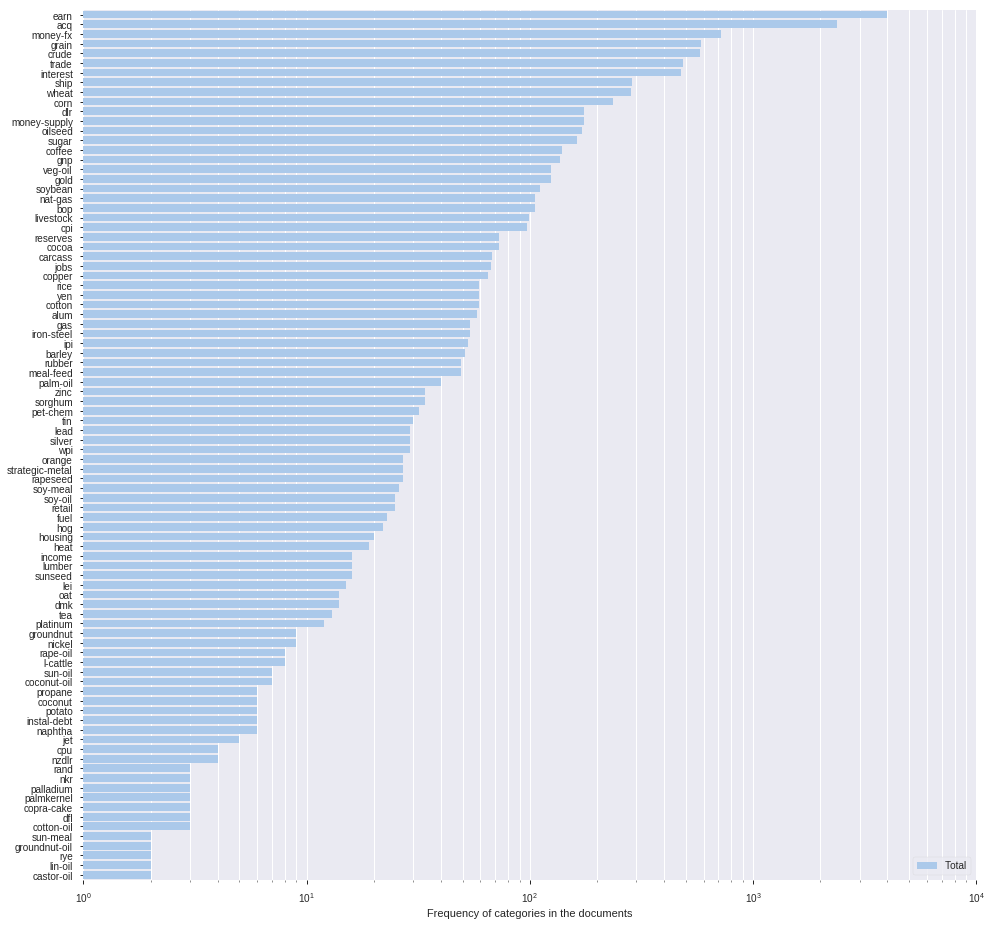

In [12]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))
# Log scale
ax.set_xscale('log')

# Plot the total crashes
sns.set_color_codes("pastel")
g = sns.barplot(x="frequency", y="categories", data=df_categories,
            label="Total", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(1, 10000), ylabel="", xlabel="Frequency of categories in the documents")
ax.grid(linestyle='-', linewidth=1, which='both', axis='x')
sns.despine(left=True, bottom=True)

Before applying traditional machine learning techniques, we have to represent and weight every document with respect to the set of textual features (e.g., the words that appear in the document). We are going to apply the following transformations:

* Lowercase the original content
* Tokenize the text
* Stem or lematize each one of the tokens
* Weight each of these features, for each document
* Normalise the representation

Clean up the documents.<br>
Remove accents and special characters, normalize the text, remove stopwords, lematize...

In [13]:
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer
from wordcloud import WordCloud

nltk.download('wordnet')

stop_word_list = stopwords.words('english')
# stop_word_list.remove('no')
# stop_word_list.remove('not')

lemma = WordNetLemmatizer()
token = ToktokTokenizer()

[nltk_data] Downloading package wordnet to /home/greg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
def clean_text(text):
    text = text.lower()
    text = text.replace(r"i'm ", "i am ")
    text = text.replace(r"he's ", 'he is ')
    text = text.replace(r"she's ", 'she is ')
    text = text.replace(r"it's ", 'it is ')
    text = text.replace(r"\'s", ' ')
    text = text.replace(r"d\''", '')
    text = text.replace(r"\'ve ", " have ")
    text = text.replace(r"can't ", "cannot ")
    text = text.replace(r"what's ", "what is ")
    text = text.replace("\n", " ")
    
    text = text.replace("u.s.", "united states")
    text = text.replace(" ec ", " european community ")
    text = text.replace(" dlrs", " dollars")
    text = text.replace(" mln", " million")
    text = text.replace(" pct", " percentage")
    text = text.replace(" x ", " ")
    text = text.replace(" e ", " ")
    text = text.replace(" e.", " ")
    text = text.replace("1st ", "first ")
    text = text.replace("2nd ", "second ")
    text = text.replace("qtr", "quarter")
    text = text.replace("cts", "cents")
    text = text.replace("shr", "share")
    text = text.replace(" vs ", " versus ")
    text = text.replace(" inc ", " incorporated ")
    text = text.replace("wk", "week")
    text = text.replace("prev ", "previous ")
    
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"\'", " ", text)
    text = re.sub(r"@", " ", text)
    text = re.sub(r" n't ", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"let\'s", "let us", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"y\'all", "you all", text)
    text = re.sub(r" doin\' ", " doing ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    # Extend with other cleaning text operations...
    return text

In [15]:
# Function to remove accents and normalize the text
def remove_accents(data):
    data = unicodedata.normalize('NFKD', data).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return data

In [16]:
# Remove special characters and digits
def remove_special(text):
    str = "`1234567890-=~@#$%^&*()_+[!{;”:\’'><.,/?”}]"
    for w in text:
        if w in str:
            text = text.replace(w, ' ')
    return text

def remove_stop_words(text):
    word_list = [x.strip() for x in token.tokenize(text)]
    removedList = [x for x in word_list if not x in stop_word_list]
    
    return ' '.join(removedList)

def lemmatize(text):
    # Reduce variations for inflections and derivations
    listLemma = []
    for w in [y.strip() for y in token.tokenize(text)]:
        x = lemma.lemmatize(w, 'v')
        listLemma.append(x)
    text = ' '.join(listLemma)
    return text

In [17]:
def text_pre_process(text):
    text = remove_accents(text)
    text = remove_special(text)
    text = remove_stop_words(text)
    return(text)

In [18]:
df['processed_text'] = df['text'].map(lambda t: clean_text(t))
df['processed_text'] = df['processed_text'].map(lambda t: text_pre_process(t))
df['lematized'] = df['processed_text'].map(lambda t: lemmatize(t))

## Visual Representation of the words

First we gather all the entries in the dataest together

In [19]:
all_text = ' '.join(df['processed_text'].tolist())

### Worldcloud

Wordcloud creates a nice graph with the words in different sizes depending on how frequent these words are in the dataset. <br>
We customize the final result to avoid repetitions of the words by setting 'collocations' to False

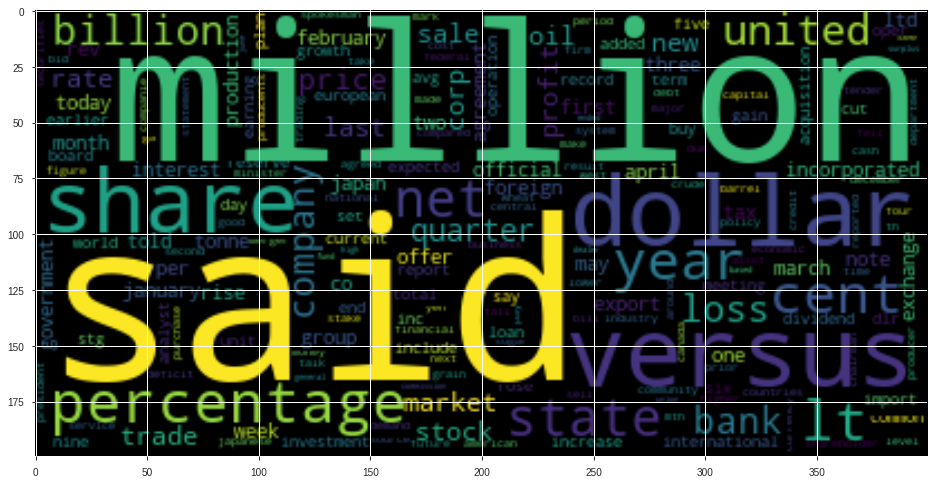

In [20]:
wc = WordCloud(max_font_size=100, 
               max_words=200, 
               collocations=False, 
               background_color='black').generate(all_text)
plt.figure(figsize=(16, 12))
plt.imshow(wc, interpolation='bilinear')

### Frequency Distribution graph

Using the same set of words but now plotted using the more classical frequency distribution graph.

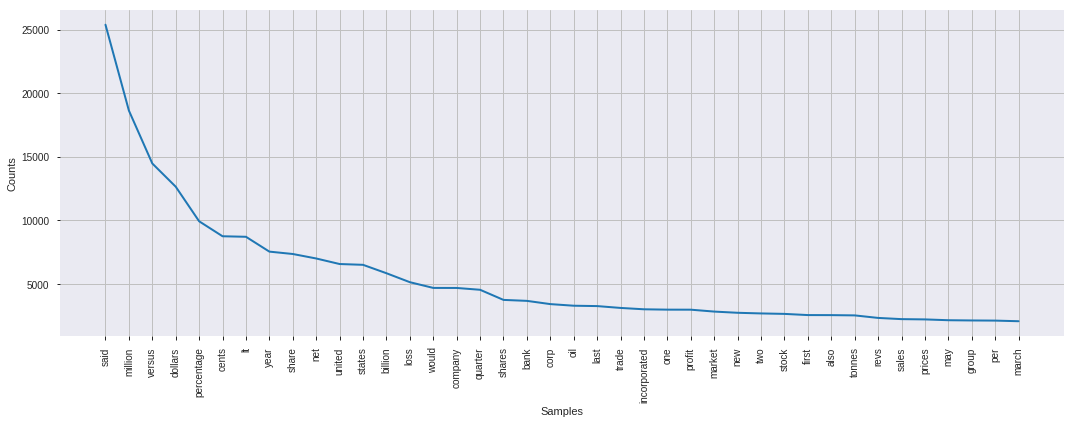

In [21]:
word_freq_dist = nltk.FreqDist(ToktokTokenizer().tokenize(all_text))
plt.figure(figsize=(18, 6))
word_freq_dist.plot(40)

### Word cound per entry

In [22]:
df['n_words'] = df['processed_text'].str.split(' ').apply(len)

Text(0, 0.5, 'Count')

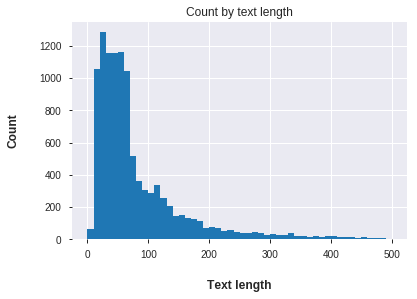

In [23]:
ax = df['n_words'].hist(bins=50, range=[0, 500])
ax.set_title("Count by text length")
ax.set_xlabel("Text length", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Count", labelpad=20, weight='bold', size=12)

The result shows a skewed distribution with a long left tail but most of the entries are below 100 words.

## Frequency Distribution of words per category

First we allocate each word with its corresponding category

In [24]:
genres = df_categories['categories']

def get_docs_with_genre(df, genre):
    includes_category = df['categories'].map(lambda x: genre in x)
    return df.loc[includes_category, 'processed_text']
    
# List of pairs genre-word
genre_word_pairs = [(genre, word)
                    for genre in genres
                    for word in ' '.join([*get_docs_with_genre(df, genre).values]).split()]
print('Length of pairs list: {}'.format(len(genre_word_pairs)))

Length of pairs list: 1244011


Now we use this list of pairs to create a ConditionalFreqDistWe can and save it in a variable. <br>We can type the name of the variable to inspect it and verify that it has two conditions

In [25]:
cfd = nltk.ConditionalFreqDist(genre_word_pairs)
from pprint import pprint as pp
print('Number of conditions: {}\nExample of first 5 conditions: {}'.format(
    len(cfd.conditions()), cfd.conditions()[:5]))

Number of conditions: 90
Example of first 5 conditions: ['earn', 'acq', 'money-fx', 'grain', 'crude']


Choosing the category 'barley' as example and the 20 most common words within that category, we obtain the following plot:

In [26]:
barley_most_common = cfd['barley'].most_common(20)
common_term, common_freq = zip(*barley_most_common)
common_barley_df = pd.DataFrame({'term': common_term, 'freq': common_freq})

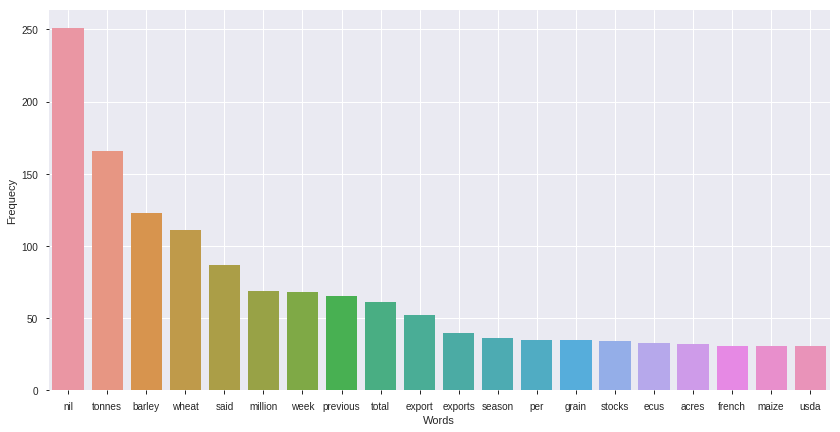

In [27]:
f, ax = plt.subplots(figsize=(14, 7))

# Plot the total crashes
sns.set_color_codes("pastel")
g = sns.barplot(x="term", y="freq", data=common_barley_df)

# Add a legend and informative axis label
ax.set(ylabel="Frequecy", xlabel="Words")
ax.grid(linestyle='-', linewidth=1, which='both', axis='x')
sns.despine(left=True, bottom=True)

## Extract features vectors

Now we want to weight each of feature as per its “importance” for the document.<br>

To explain in a simple way what "tf-idf" does, the terms weight is higher the more common the term is in the document, and the more uncommon in the collection. More detailed explenation at https://en.wikipedia.org/wiki/Tf%E2%80%93idf

The tf_idf function will convert the text to vectors and after that step we can use the new data to fit the model. <br>
When obtaining very long vectors there is the question if we really need that many features and we may be better off by selecting the best features instead of using them all. The method 'SelectKbest' allows to do precisely that (found in the sklearn.feature_selection package), after which Chi2 score can be used to select the features with the highest values for the test chi-squared.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2

X_all = df['processed_text']

In [29]:
label_list = df_categories["categories"].values
nlabels = len(label_list)

def tf_idf(docs):
    tfidf = TfidfVectorizer(min_df=5,              # Minimum number of documents a word must be present in
                            tokenizer=token.tokenize,
                            max_features=3000,
                            use_idf=True,
                            sublinear_tf=True,     # Use logarithmic form for frequency
                            norm='l2')             # Ensure that all feature vectors have a euclidian norm of 1
    # Other parameters
    #   ngram_range set to (1, 2) to indicate that we want to consider both unigrams and bigrams
    #   
    #   max_df=0.90,
    tfidf.fit(docs)
    return tfidf

In [30]:
def feature_values(doc, representer):
    doc_representation = representer.transform([doc])
    features = representer.get_feature_names()
    return [(features[index], doc_representation[0, index])
                 for index in doc_representation.nonzero()[1]]

In [31]:
X_train = df[df['doc_set'] == 'train']['lematized']
y_train = df[df['doc_set'] == 'train']['categories']

X_test = df[df['doc_set'] == 'test']['lematized']
y_test = df[df['doc_set'] == 'test']['categories']

In [32]:
tfidf = tf_idf(X_train)

In [33]:
for doc in df[df['doc_set'] == 'test']['lematized']:
    [pp(k) for k in feature_values(doc, tfidf)]

('yesterday', 0.03908705154846454)
('year', 0.04722938940617371)
('yasuhiro', 0.06578198288495891)
('would', 0.054368386594078326)
('worry', 0.06175647433726683)
('world', 0.06302717693223528)
('work', 0.04105259659007966)
('whose', 0.05890033056924751)
('whole', 0.05654410651080432)
('week', 0.033655825108509396)
('washington', 0.0491183111354744)
('warn', 0.054189852123167896)
('want', 0.043028575450705604)
('virtually', 0.06509701298657136)
('view', 0.08544121223434101)
('us', 0.052850356179887335)
('unite', 0.09883299303048856)
('two', 0.04506327824459336)
('trade', 0.10976900101961196)
('tough', 0.06385437757419712)
('tokyo', 0.08807527842142962)
('time', 0.03565740934373791)
('threat', 0.06224086921855204)
('third', 0.04320942062706294)
('textile', 0.06863812665297823)
('term', 0.07048472429822451)
('tell', 0.03123070982120116)
('tax', 0.03433382545542153)
('tariff', 0.1312874162240053)
('talk', 0.03948029604911289)
('taiwan', 0.12984535264950678)
('surplus', 0.09294323831859226)

('yen', 0.04959206933671778)
('years', 0.08749470913068923)
('within', 0.04963955487335068)
('will', 0.06409831273537216)
('widely', 0.06977302086422787)
('whether', 0.05002700941538071)
('weak', 0.06357886722344155)
('want', 0.0806670331733426)
('wall', 0.06582246393068664)
('wait', 0.06230289923528631)
('view', 0.055874943154958195)
('various', 0.06089161988075066)
('universal', 0.1376041582109271)
('unite', 0.06620413648376622)
('two', 0.061845013241438755)
('trust', 0.05347241658434099)
('trillion', 0.08127123252534943)
('tokyo', 0.057597511159568265)
('time', 0.08285646544877728)
('tie', 0.06762122330954952)
('three', 0.0711432795182751)
('things', 0.06646300731562127)
('tell', 0.03458010118366652)
('take', 0.036178338012364177)
('swiss', 0.06409831273537216)
('sumitomo', 0.2928939794204282)
('subsidiary', 0.07497955918797607)
('subsidiaries', 0.10736421286393)
('strengthen', 0.06374930295742297)
('strategy', 0.06374930295742297)
('status', 0.06977302086422787)
('state', 0.0628216

('wish', 0.12487821825047564)
('whether', 0.17999982464782704)
('washington', 0.0932444859376995)
('unite', 0.12412046870754789)
('turn', 0.1014604417222329)
('trade', 0.131808676084862)
('top', 0.09926216186130699)
('today', 0.060932865500403284)
('threaten', 0.10656136072891881)
('team', 0.12487821825047564)
('tariff', 0.09551154419750747)
('take', 0.10502160531131054)
('step', 0.09481599637605344)
('state', 0.1260081841049758)
('situation', 0.09388343549759193)
('settle', 0.11181432990116603)
('security', 0.1014604417222329)
('secretary', 0.08585558758165505)
('say', 0.06896050094352855)
('sanction', 0.20005531502213253)
('result', 0.0636020902515256)
('reply', 0.11395025908496323)
('remove', 0.11115295653501599)
('reduce', 0.15170674587632957)
('question', 0.09565378794390816)
('protectionist', 0.11181432990116603)
('problems', 0.1562185462881453)
('probably', 0.09337055468157186)
('press', 0.09238485519366273)
('political', 0.17245229937271006)
('persuade', 0.1294234494404815)
('p

('wet', 0.12971315152097887)
('towards', 0.1037675370401631)
('summer', 0.10761655288374931)
('sugar', 0.19081121703187973)
('stress', 0.10701475892984755)
('spokesman', 0.14631951712558633)
('southern', 0.09918272331000616)
('since', 0.11552702700666172)
('severe', 0.11330884837536186)
('season', 0.0969995898296799)
('say', 0.07184444409525739)
('run', 0.08797066540684895)
('restore', 0.11289640245115906)
('report', 0.09704056459974265)
('relieve', 0.12971315152097887)
('region', 0.22715117186000827)
('record', 0.0563901008443222)
('rainfall', 0.128720851957777)
('rain', 0.26940404855992267)
('put', 0.08172060845011209)
('producers', 0.08202148520866231)
('probably', 0.09092256728992022)
('previously', 0.0745294652866896)
('past', 0.08402271093427467)
('partly', 0.09899054279766706)
('outlook', 0.09769883902144713)
('one', 0.04810502448586295)
('north', 0.08850267573587689)
('normally', 0.11416263353594726)
('need', 0.07331035379448572)
('much', 0.07851173778179311)
('moisture', 0.216

('year', 0.025894016053320118)
('would', 0.12083109062687383)
('without', 0.06072162919630365)
('within', 0.05865358618741183)
('williams', 0.09602925033564079)
('william', 0.07827478622760951)
('want', 0.05629477207049414)
('violate', 0.0820966860272118)
('use', 0.050225074420568214)
('two', 0.03482083390769657)
('treatment', 0.14910800171992153)
('trade', 0.06445343361779635)
('towards', 0.07343973841802506)
('together', 0.07226573269101223)
('time', 0.0466509920582815)
('three', 0.06782082582323247)
('tender', 0.11231529061476213)
('takeovers', 0.21284739992734292)
('takeover', 0.14928682744947244)
('suit', 0.13168476690190933)
('stock', 0.07957573496500402)
('spring', 0.07729401265274195)
('speak', 0.07194891017614903)
('shortly', 0.07933570863609794)
('shareholders', 0.10527989252097102)
('several', 0.057369669819087206)
('senate', 0.12318652280334781)
('securities', 0.04993447887458826)
('sec', 0.0831648831931772)
('say', 0.0675352339422301)
('reserve', 0.0837813911496202)
('requ

('zambia', 0.1605497523811536)
('would', 0.05541499964200652)
('week', 0.07199019389358956)
('way', 0.0985347678129316)
('subsidy', 0.22725965459763808)
('subsidies', 0.12839516944901413)
('spend', 0.10382720759002644)
('say', 0.05041752464664332)
('rule', 0.09664363095116123)
('rise', 0.06408719285498347)
('retail', 0.23767770649254807)
('refine', 0.11950328014760248)
('reduce', 0.0814528058011116)
('raise', 0.07891016505021267)
('producer', 0.18037060740024097)
('price', 0.17864299681426757)
('pressure', 0.0985347678129316)
('president', 0.07953912634517366)
('practice', 0.1224992780346627)
('plan', 0.11778987147619847)
('percentage', 0.04609659559094802)
('per', 0.06575448455205254)
('people', 0.18194558794337998)
('party', 0.11165119399969335)
('official', 0.07882769359091982)
('monetary', 0.10278472226454534)
('ministry', 0.09508345503134576)
('meal', 0.3003431123105962)
('maize', 0.2980010194909327)
('level', 0.0770142116339136)
('least', 0.09812239807778969)
('lead', 0.082699542

('year', 0.032381354624051596)
('would', 0.0423858532933935)
('world', 0.17002697881216797)
('within', 0.07334831995145194)
('west', 0.0653059673155477)
('weight', 0.09726048423880679)
('weeks', 0.07568898343690798)
('two', 0.04354464632865436)
('top', 0.08554816398813601)
('tomorrow', 0.08025395716111276)
('three', 0.0848122673345041)
('term', 0.05495022697354108)
('surpluses', 0.09991836420515877)
('support', 0.07081429790878666)
('stock', 0.12373455898496101)
('source', 0.15404073577879646)
('soon', 0.08113816393531582)
('set', 0.05241721182950468)
('september', 0.07117933099376257)
('sell', 0.08951544247959894)
('say', 0.054350609453069076)
('sales', 0.14437697936660066)
('rule', 0.1251588447540185)
('rise', 0.0490190448774744)
('represent', 0.07861803098171899)
('recently', 0.07951788934763744)
('range', 0.07111791962127058)
('producers', 0.17322750749631988)
('producer', 0.1379619625209126)
('produce', 0.06716566646495915)
('private', 0.07199955476287406)
('price', 0.129490555126

('management', 0.054758150386770454)
('makers', 0.08438701345280102)
('maker', 0.07533455526575861)
('make', 0.06447397767420372)
('maintain', 0.0643539803041309)
('lucky', 0.09759845715736276)
('lt', 0.04946629654643051)
('lot', 0.07366505954687383)
('look', 0.12970108174308248)
('line', 0.05768263007765247)
('level', 0.04736216797083647)
('less', 0.05752988054064252)
('last', 0.07307916351391243)
('largest', 0.09819169294574633)
('know', 0.06570155988070331)
('jointly', 0.08093014549349335)
('johnson', 0.14498717022027965)
('j', 0.12144386613985088)
('investor', 0.06570155988070331)
('industry', 0.050381401944881776)
('industries', 0.08798830722147871)
('industrial', 0.05609327583042713)
('incorporate', 0.08992471064119906)
('inc', 0.04423586583478279)
('however', 0.10933820049011338)
('heavily', 0.08478888936204398)
('h', 0.07298646865409991)
('foreign', 0.046749339150044006)
('force', 0.060469455670250534)
('focus', 0.1265695549269309)
('five', 0.043266713970857115)
('find', 0.1050

('york', 0.09740543899723998)
('versus', 0.14366016246134938)
('unite', 0.05609868857718223)
('texas', 0.11198639636065218)
('tax', 0.1834350038053719)
('state', 0.05323251988851535)
('series', 0.26312127095751725)
('securities', 0.08545262888363211)
('record', 0.19066693612725785)
('qtly', 0.0886183692009774)
('prior', 0.2211932798378569)
('pay', 0.1967275809376288)
('new', 0.06459877126267587)
('national', 0.08496621675152322)
('mutual', 0.13826698642840474)
('may', 0.23307448458641322)
('lord', 0.4841143334806809)
('income', 0.22443394767645788)
('government', 0.07566665976025069)
('fund', 0.21410486754659186)
('free', 0.2567293278409716)
('dividends', 0.12059716796286958)
('div', 0.2314374095803082)
('daily', 0.2935057994150201)
('co', 0.06703717496980041)
('cents', 0.17367287655179722)
('california', 0.1256770643007589)
('bond', 0.11549415342482762)
('april', 0.06514427465008057)
('yield', 0.06532885080322694)
('years', 0.048072658884694114)
('year', 0.06593685851792078)
('world',

('would', 0.11778361237893567)
('white', 0.23898461170325738)
('unite', 0.11391668590451258)
('trade', 0.07812970311685806)
('term', 0.09018591546463002)
('tariff', 0.2835203715715407)
('take', 0.08773646491776192)
('state', 0.10809650638628732)
('spokesman', 0.10127552136892495)
('semiconductor', 0.15501893442591022)
('schedule', 0.1271802874953843)
('say', 0.08920180569856048)
('remark', 0.15459909961989482)
('put', 0.11870418524633801)
('provision', 0.12688407379002029)
('press', 0.1306763434191223)
('presidential', 0.181881581691214)
('position', 0.12120174274478905)
('pact', 0.12793554931589055)
('one', 0.06987549219405831)
('officials', 0.1059450808788984)
('meet', 0.09026038187955308)
('make', 0.07773057429961842)
('likely', 0.18799839505170227)
('july', 0.12503497831340732)
('japanese', 0.24187129476696193)
('japan', 0.1700651686324953)
('indications', 0.17760701352346825)
('impose', 0.14351356072547952)
('house', 0.18869176570002516)
('high', 0.10635106272288682)
('goods', 0.1

('div', 0.30082094217400474)
('corp', 0.1984884808630882)
('cents', 0.30618792914348075)
('april', 0.40024274630206974)
('aid', 0.42407119996403897)
('versus', 0.357787417600873)
('six', 0.1873555847745969)
('share', 0.18623931945748792)
('sales', 0.2984232678481939)
('rd', 0.25964520829708426)
('quarter', 0.1409712008628127)
('nine', 0.20812654087382976)
('net', 0.22500797280327925)
('mths', 0.2329876920850256)
('lt', 0.0878691235335517)
('loss', 0.5297413478888535)
('jan', 0.22199097465686962)
('incorporate', 0.13653750541714377)
('five', 0.18340232008752896)
('cents', 0.29617853032369684)
('trade', 0.23720868655765162)
('steel', 0.42702537631043697)
('say', 0.11349168541665301)
('plan', 0.26514929347557187)
('monitor', 0.5422852591037051)
('minister', 0.31885353667694094)
('import', 0.3029882963706973)
('export', 0.2681454616804473)
('canada', 0.34460423687066377)
('year', 0.10554444729230412)
('volume', 0.08646964501556623)
('video', 0.10300455388189494)
('various', 0.0917248593008

('promote', 0.12211767282668116)
('product', 0.0921882492880227)
('probably', 0.1677049295315834)
('price', 0.057091875370204305)
('policy', 0.08601258067827726)
('pick', 0.12436649802201138)
('percentage', 0.04339869419095898)
('participants', 0.1317715552735474)
('part', 0.07842526628432256)
('pace', 0.12690070445520343)
('national', 0.12939750451618742)
('much', 0.08552912261321927)
('move', 0.07950625765463226)
('money', 0.08012148989123259)
('meet', 0.06769274935387233)
('market', 0.055313856591354175)
('march', 0.05782935435084679)
('manage', 0.1093520667523221)
('lower', 0.07375449474899623)
('little', 0.09800358448909975)
('line', 0.08830639682411984)
('like', 0.10256073746988437)
('last', 0.053309973482959544)
('japanese', 0.08643648638238668)
('japan', 0.07532959787254918)
('inventory', 0.11050808061242763)
('interest', 0.13955510363123222)
('inflation', 0.09688910882010546)
('however', 0.07976030770648872)
('higher', 0.0766856069226112)
('growth', 0.20746664299975134)
('gros

('years', 0.0779049967453496)
('year', 0.040949485937986745)
('would', 0.11248810058017808)
('without', 0.09602680000605242)
('volume', 0.10726298608208706)
('total', 0.06614029680079765)
('tell', 0.10940488277170059)
('slightly', 0.10190142922759199)
('since', 0.0763673181420563)
('shipment', 0.10895226150142046)
('sell', 0.06685850978530956)
('say', 0.06873182247497304)
('roughly', 0.14105658835357257)
('reuters', 0.08416251895021432)
('remain', 0.1294369666126299)
('registrations', 0.3788345960468376)
('register', 0.2703500169875795)
('recent', 0.08369959737937854)
('private', 0.15416222291247741)
('president', 0.07693569008346923)
('policy', 0.1496221589616418)
('plan', 0.06729150992320998)
('per', 0.10768795422519815)
('open', 0.17601475264484934)
('new', 0.10107484970575796)
('national', 0.07851821468112563)
('month', 0.12074937798885842)
('mean', 0.16137313885305613)
('may', 0.1073256655073207)
('market', 0.05682941251871816)
('march', 0.05941383292751788)
('lower', 0.0757753095

('year', 0.06330437939757579)
('versus', 0.21656451067782476)
('turnover', 0.16045031471340307)
('tax', 0.10981650923726219)
('stg', 0.3246813630095226)
('share', 0.06309535532143702)
('reuter', 0.19199106749099254)
('profit', 0.20627334386124002)
('pre', 0.1568935892666558)
('plc', 0.1375121757650704)
('p', 0.40617525028022233)
('oil', 0.17911096139614657)
('note', 0.08756772409923348)
('net', 0.12906801566067438)
('name', 0.1415248351900865)
('minorities', 0.37171113678373396)
('million', 0.16966117411861364)
('make', 0.09258942598723807)
('lt', 0.05040307359345668)
('l', 0.14037923846491557)
('full', 0.13084014484251394)
('final', 0.14596946296460095)
('extraordinary', 0.145087321711417)
('duties', 0.20331729567847112)
('div', 0.1184308914634416)
('debit', 0.2180613402372113)
('company', 0.07422170846340852)
('co', 0.09576904149485999)
('climb', 0.196780454842301)
('billion', 0.15482897190026543)
('year', 0.05723479493791226)
('wheat', 0.37729139505555104)
('weather', 0.155155208616

('yesterday', 0.07237104412043205)
('year', 0.03664546549579499)
('vehicles', 0.21829011001161372)
('value', 0.07228202567918485)
('u', 0.07419906788659443)
('turnover', 0.15726126770348572)
('transfer', 0.10074751018663068)
('transaction', 0.0860273938774787)
('trade', 0.05387312602469076)
('today', 0.059429735290495014)
('sum', 0.11769575840386616)
('stg', 0.23202742979779303)
('statement', 0.12164125906220491)
('share', 0.08715812776454397)
('service', 0.15049921402368133)
('sell', 0.059831305749434016)
('say', 0.06725933997879534)
('retail', 0.16598535588894356)
('represent', 0.08897077886754114)
('qualify', 0.11524114799819991)
('purchase', 0.0667950463155516)
('plc', 0.20771822789424035)
('place', 0.08640642322728541)
('payable', 0.08055252006067347)
('part', 0.07210527170010167)
('p', 0.1890972389302081)
('own', 0.06983296631453739)
('ordinary', 0.10905602375890887)
('operations', 0.06859324233384273)
('note', 0.050690963920051346)
('north', 0.08864348941121622)
('new', 0.053422

('yesterday', 0.062332986043355416)
('years', 0.06004684536000925)
('work', 0.06546748421584278)
('within', 0.07149381866381793)
('west', 0.06365480474553889)
('well', 0.06336504969924095)
('welcome', 0.16261630592601747)
('washington', 0.07833005768379549)
('view', 0.08047439313192359)
('unite', 0.03995781449455833)
('undertake', 0.1694315413877945)
('trade', 0.04640077883940483)
('tokyo', 0.08295533730783122)
('today', 0.05118667148505163)
('sustain', 0.09925689144180841)
('summit', 0.1110433209704049)
('strong', 0.07011620218864341)
('strengthen', 0.09181551118278884)
('stimulate', 0.09283732388221451)
('statement', 0.12985883438254558)
('state', 0.06419788999633581)
('stability', 0.08713754398367728)
('seven', 0.10983438417941625)
('service', 0.06176680169565919)
('rise', 0.047779672497792976)
('resist', 0.09572394847210867)
('reduce', 0.06072646049593379)
('recent', 0.06451315051026674)
('reaffirm', 0.22261513744006461)
('rat', 0.06229460395983265)
('range', 0.069319810631197)
('p

('share', 0.1800163897125863)
('say', 0.1270380454227467)
('p', 0.4441003811573918)
('offer', 0.30351166483539)
('j', 0.49758487271615737)
('industries', 0.5080960867049265)
('dollars', 0.17660871015472046)
('company', 0.21176081706514124)
('buy', 0.283417247512036)
('year', 0.09147416185362314)
('versus', 0.2229280344032522)
('two', 0.12300936981702223)
('third', 0.19970482877959633)
('split', 0.20320925659273031)
('share', 0.15436782514308706)
('result', 0.1548466372850895)
('restate', 0.2594359447644203)
('quarter', 0.11684652708349841)
('percentage', 0.20902492956401053)
('one', 0.12027048951325682)
('note', 0.1265344395385297)
('net', 0.23116432761456965)
('national', 0.1753962892006925)
('million', 0.19858739085370797)
('lt', 0.07283191077274023)
('loan', 0.18946573008275505)
('july', 0.21521162249947876)
('incorporate', 0.11317157849966322)
('first', 0.13790015599526684)
('earlier', 0.1598719718209112)
('dollars', 0.21344508557722683)
('deposit', 0.22610581698469923)
('december'

('zone', 0.09280154706452838)
('yet', 0.044980154467854326)
('yesterday', 0.09250864995454801)
('yen', 0.10600278056832202)
('years', 0.05782323041935905)
('year', 0.017951088146748808)
('would', 0.0560713112337678)
('worth', 0.043691572874460335)
('worry', 0.09483740664200613)
('word', 0.06143491496179046)
('within', 0.04066173797085278)
('wilson', 0.10614920545925534)
('willingness', 0.05999107590210121)
('whose', 0.05342200648685293)
('whether', 0.0409791174297105)
('west', 0.08639182496635239)
('welcome', 0.05462441794927787)
('weeks', 0.041959319774860726)
('week', 0.0305254943374785)
('weak', 0.052079984321356534)
('washington', 0.0754293909539546)
('warn', 0.04914964998782113)
('want', 0.03902648448034003)
('volcker', 0.09946743961396162)
('view', 0.04576939304753773)
('unite', 0.07265948445158281)
('unit', 0.032736264738067795)
('understand', 0.05499966849401754)
('undermine', 0.06225408943995476)
('treasury', 0.040430835320263245)
('trade', 0.07367509611442485)
('tokyo', 0.099

('weather', 0.19496362958081934)
('temperatures', 0.24034951177834937)
('santa', 0.39850844795768653)
('reuter', 0.21811957396505408)
('report', 0.11266166766037188)
('rainfall', 0.2530267738463246)
('rain', 0.22192062945981142)
('mm', 0.25922655712650455)
('hours', 0.21214836585251937)
('grain', 0.2745192572542356)
('gmt', 0.21276507591173316)
('fe', 0.2570394232610884)
('buenos', 0.27618271823055934)
('argentine', 0.39656913920032416)
('air', 0.19855432494637212)
('year', 0.05722769305839967)
('would', 0.07490868218622974)
('worry', 0.10546435615758912)
('west', 0.06816624657453575)
('upper', 0.11233890124367452)
('unchanged', 0.13743512313398532)
('transactions', 0.09144825709157203)
('total', 0.09243233504419401)
('today', 0.0928089356686342)
('three', 0.05228540500068373)
('statement', 0.0662639742476109)
('spokesman', 0.13517114303499547)
('speculate', 0.10807793690062191)
('slightly', 0.08410917022469688)
('since', 0.06303338245499876)
('shareholders', 0.06548251269104385)
('sha

('hold', 0.04662110821379373)
('group', 0.04483608460290303)
('global', 0.08589277184943643)
('give', 0.05001649987307071)
('german', 0.1409154243709368)
('generally', 0.08288093614162759)
('g', 0.13994957132371677)
('fund', 0.057532380967279466)
('french', 0.06950756942075345)
('franc', 0.1802556265109936)
('follow', 0.05537350060805612)
('firm', 0.054668703294335465)
('finance', 0.05517780110327705)
('february', 0.04955059428348119)
('factor', 0.0679175869239523)
('every', 0.08117703240907241)
('european', 0.05795903991709895)
('end', 0.11326723786816706)
('ems', 0.09996621435486443)
('edge', 0.09345593482735434)
('ease', 0.07357848698017654)
('early', 0.0585212117333153)
('dollar', 0.13182542982461565)
('direction', 0.08736347981463974)
('dip', 0.16361973235433933)
('describe', 0.08507808021067527)
('dealers', 0.13820797031199683)
('days', 0.06364012913956152)
('day', 0.058157279876986684)
('cut', 0.11091515932711847)
('current', 0.04860073135093784)
('currency', 0.05967232138757347

('versus', 0.17361655030817263)
('record', 0.23042529773798134)
('raise', 0.27866897563635745)
('quarterly', 0.3185513774985812)
('qtly', 0.29898990213129023)
('prior', 0.26731707342410227)
('pay', 0.23774972384603918)
('may', 0.2314288570940329)
('lt', 0.11903655552095968)
('june', 0.3137423172411706)
('four', 0.26582704473768304)
('eight', 0.3001466702097779)
('div', 0.27969733553937204)
('corp', 0.18455064608018787)
('cents', 0.2846874533961557)
('yen', 0.27879654992552044)
('year', 0.0587050785523542)
('washington', 0.14569034889717947)
('unite', 0.07431971974770157)
('trade', 0.0863033407367483)
('state', 0.07052261041958795)
('spokeswoman', 0.1798642975233517)
('size', 0.16986651844520093)
('see', 0.10083664532206349)
('say', 0.06991265187642207)
('reserve', 0.11218353378442826)
('report', 0.0919611674663424)
('remain', 0.10959502350998573)
('relatively', 0.1673042143840334)
('reaffirm', 0.1972989698316478)
('paris', 0.14324278778073746)
('open', 0.2035817246281591)
('night', 0.1

('year', 0.09949540005564372)
('traditional', 0.18067750067874314)
('trade', 0.08638935362386613)
('total', 0.09491306017656363)
('third', 0.12829165804434275)
('surplus', 0.22263850398140533)
('statistics', 0.1418013140190007)
('show', 0.1148601975066889)
('sharply', 0.14411794066248934)
('rise', 0.15061659825705068)
('register', 0.16257816703465053)
('plan', 0.09656508119323154)
('period', 0.11438309834930192)
('percentage', 0.10833541164534972)
('one', 0.07726253094505492)
('non', 0.12579913719461264)
('national', 0.11267569689672366)
('million', 0.12757380878075752)
('major', 0.10748268888018085)
('last', 0.13307676716416622)
('january', 0.1720758303455952)
('institute', 0.14982789038954297)
('government', 0.10034333581388605)
('forecast', 0.12232721500112424)
('fob', 0.1942767079184074)
('figure', 0.11267569689672366)
('export', 0.25482794660364677)
('drop', 0.12368585495397713)
('dollars', 0.1205880322659364)
('dlr', 0.16814955441278767)
('department', 0.11472309368404805)
('comp

('yesterday', 0.08613329984850186)
('would', 0.09666007319927272)
('will', 0.12756759481377614)
('wall', 0.1309989771964857)
('volume', 0.11424255806177408)
('upward', 0.13227377797521034)
('unite', 0.05521472073801742)
('unit', 0.07953619945134423)
('ual', 0.4893624344793871)
('two', 0.05864976075412566)
('trump', 0.16174490744572584)
('traders', 0.2097753285598742)
('trade', 0.10856082515100622)
('target', 0.09697533490971005)
('takeover', 0.2211346318269319)
('street', 0.13018859231879773)
('stock', 0.10813598384024976)
('stake', 0.08744636728017127)
('speculation', 0.2655453905154279)
('share', 0.04347004852945213)
('session', 0.11869687366584934)
('say', 0.08004954147635866)
('rumor', 0.13827787717451184)
('rise', 0.06602316235986447)
('real', 0.10098158545593293)
('pay', 0.06935686029757539)
('partner', 0.10511743997440785)
('participate', 0.13362748126884152)
('movement', 0.1377095883329881)
('million', 0.0396785420588571)
('might', 0.16554612923365195)
('lt', 0.0347255997526127

('wheat', 0.33971779806433905)
('versus', 0.2004688355248959)
('usda', 0.16964177927338545)
('unite', 0.09158349355674142)
('tonnes', 0.37163086712358245)
('state', 0.08690435134702808)
('output', 0.16158111755431442)
('month', 0.3006454030047643)
('million', 0.2026702468482791)
('last', 0.2308936933793569)
('forecast', 0.254975425761469)
('export', 0.20355197664142177)
('estimate', 0.2764503919187637)
('department', 0.14123143616928022)
('crop', 0.2917578256897497)
('australian', 0.192476011861222)
('australia', 0.3224759165456)
('agriculture', 0.1473625138155989)
('wheat', 0.32659195922430895)
('versus', 0.19272322536687309)
('usda', 0.276130715513355)
('unite', 0.0880449383686348)
('tonnes', 0.3572719877900924)
('state', 0.08354658641160834)
('project', 0.2938272114612198)
('month', 0.289029222956732)
('million', 0.19483957970938576)
('last', 0.22197254345508127)
('import', 0.22111485165086184)
('estimate', 0.26576904607152135)
('department', 0.13577460970664995)
('crop', 0.28048503

('years', 0.10986248881154537)
('whose', 0.17185492789670587)
('three', 0.08933086157722477)
('subject', 0.1272690059600899)
('stock', 0.08456323868382774)
('shareholders', 0.11187843484918988)
('share', 0.057556742772876306)
('sell', 0.09428461061688742)
('say', 0.09692637690925254)
('satisfactory', 0.18088641471725803)
('result', 0.09775430970178114)
('purchase', 0.10525835687713231)
('price', 0.0827175486722446)
('performance', 0.15075965446834774)
('payable', 0.2149246233893596)
('million', 0.11025391030281748)
('may', 0.08939083578886496)
('maximum', 0.16798685275752018)
('march', 0.08378604490013149)
('lt', 0.0778485540658865)
('international', 0.228916972207911)
('incorporate', 0.07144494532178514)
('inc', 0.09811716455741644)
('home', 0.2500484775470496)
('halt', 0.16709547369271055)
('future', 0.12513020947417183)
('entitle', 0.1854697739481099)
('enter', 0.14490135118744527)
('end', 0.0824564712207398)
('eight', 0.11593351860349592)
('earn', 0.10658615731812132)
('earlier', 0

('year', 0.03962041191863993)
('v', 0.13098797588997527)
('two', 0.053279328317887134)
('subsidiary', 0.08006347519766865)
('submit', 0.12097307259984233)
('start', 0.08143090426013223)
('say', 0.06650103306549955)
('round', 0.11008896620772506)
('result', 0.067069076437878)
('provide', 0.08087259285831101)
('plan', 0.06510746791357411)
('percentage', 0.09053544348231458)
('orange', 0.13837264511882666)
('offshore', 0.25565069722756845)
('offset', 0.10117136501757451)
('offer', 0.15888027237680633)
('netherlands', 0.2048252167960966)
('ministry', 0.08898617178047045)
('lt', 0.07527768702203115)
('louisiana', 0.30503197129049686)
('license', 0.11976818376860968)
('land', 0.2813706180341782)
('la', 0.12966251290372668)
('interest', 0.06610331986354037)
('intend', 0.09595698573569418)
('incorporate', 0.04901826337380921)
('immediately', 0.1013248374321487)
('head', 0.09955704360092278)
('group', 0.13120329357308436)
('get', 0.086793050608786)
('four', 0.07044676639317704)
('formal', 0.118

('reflect', 0.0562889874146756)
('recommendations', 0.14668767251565745)
('rate', 0.04454084366659224)
('public', 0.05570805830158533)
('provide', 0.051996541921022814)
('promote', 0.07804792709293426)
('process', 0.06255498319708044)
('priority', 0.08663610240141437)
('prevent', 0.06892170076616927)
('pressure', 0.0592898239995126)
('possible', 0.05679412194768161)
('policy', 0.09307639274335149)
('policies', 0.11538294293268105)
('perform', 0.07948519772565417)
('particular', 0.07580912724769757)
('options', 0.11907450115646213)
('need', 0.12180121223543014)
('national', 0.04884431716455058)
('must', 0.05904169504399808)
('move', 0.08603573575703187)
('monetary', 0.06184708431518622)
('medium', 0.12513155965284775)
('matter', 0.07277649079652174)
('make', 0.06308330355932974)
('lead', 0.049761535151466994)
('kind', 0.0804321671571998)
('key', 0.06447095433917857)
('keep', 0.06132239079462072)
('jam', 0.06554868575007917)
('iv', 0.15546008874237646)
('international', 0.042316864901341

('year', 0.15409386564844785)
('versus', 0.375536018986182)
('share', 0.15358506470588537)
('rev', 0.23577763480108319)
('profit', 0.4050952992879686)
('net', 0.18555621961569785)
('million', 0.2373609534861587)
('ltd', 0.2655883016132355)
('lt', 0.12268984428076343)
('loss', 0.4855067383251775)
('cents', 0.29342464735306756)
('american', 0.3062189069610532)
('year', 0.13737768461466626)
('two', 0.0880285879640011)
('trade', 0.20196128541675595)
('total', 0.10573083599376153)
('surplus', 0.3495467498545932)
('stand', 0.16138052940541)
('slightly', 0.16289801864122402)
('say', 0.046043610495117515)
('respectively', 0.16202231450526858)
('record', 0.10089207446598063)
('previous', 0.23089159288967406)
('percentage', 0.12068300842563588)
('narrow', 0.3059924218944546)
('months', 0.11920107247136656)
('month', 0.23925329563684203)
('mln', 0.22403117817008908)
('million', 0.18339401601811467)
('last', 0.1482442755237256)
('january', 0.1916882814958793)
('import', 0.12292244186396216)
('firs

('take', 0.06956054610244962)
('start', 0.08659989440438297)
('spokesman', 0.1359508885662627)
('say', 0.06219632059603885)
('return', 0.09755797704884155)
('resume', 0.20536218732417194)
('repair', 0.13930270065623485)
('pump', 0.13657166111926086)
('port', 0.18655902007050237)
('point', 0.08943083915651087)
('pipeline', 0.2957470238114889)
('per', 0.06544418325642959)
('pacific', 0.17977595841724692)
('output', 0.22458094118004637)
('oil', 0.14776548401367018)
('ocean', 0.14824026975187482)
('normal', 0.11584069932257453)
('next', 0.08240781287828614)
('new', 0.12890781325817094)
('months', 0.07672612647955547)
('month', 0.07338187894884947)
('ministry', 0.09463474769998227)
('may', 0.06522401295590621)
('march', 0.06113447793460558)
('main', 0.09935114499672615)
('link', 0.24623707033250147)
('limit', 0.09419893519340965)
('level', 0.07665077467878903)
('km', 0.2923423594418297)
('halt', 0.12192119298166619)
('government', 0.0719494262667883)
('four', 0.07491851633245586)
('finish',

('make', 0.03730702591526099)
('majority', 0.06955691533904432)
('lt', 0.042620493041304545)
('loan', 0.05283177737300492)
('little', 0.06271850908571858)
('likely', 0.05329152918021311)
('letter', 0.061476803489387714)
('let', 0.07842576725653039)
('legal', 0.07269326912207284)
('lawsuit', 0.08908288003028102)
('law', 0.0687485382172646)
('latest', 0.06054973722373228)
('last', 0.05776395804492255)
('larger', 0.07400193197547593)
('jam', 0.06563491099204005)
('issue', 0.09977614930940744)
('instead', 0.06941858914121835)
('incorporate', 0.053431410499784976)
('inc', 0.04333865292987868)
('houston', 0.08053797069841816)
('hold', 0.041851540137527905)
('hit', 0.0625565442815349)
('hear', 0.07166911878093209)
('halt', 0.07380658392634598)
('go', 0.052136023942573155)
('get', 0.05587646971845467)
('full', 0.052719375051196136)
('friday', 0.06170062929049098)
('freeze', 0.07568238251524942)
('free', 0.06192844032940113)
('file', 0.13827305999164965)
('fight', 0.08021402811279495)
('fall', 

('within', 0.20692877719176528)
('west', 0.2596646861410978)
('trade', 0.07932004564439407)
('tonnes', 0.09928325022080958)
('stay', 0.1605685324142545)
('spokesman', 0.10281850125076968)
('source', 0.10755920368139735)
('say', 0.06425562082091159)
('saturday', 0.18133438588866238)
('rise', 0.1382915249090617)
('result', 0.09133439604023358)
('relatively', 0.15376667702725852)
('rather', 0.14109300086782522)
('quarter', 0.17984375410995024)
('percentage', 0.05874872652289289)
('normal', 0.14833550039216373)
('industry', 0.10440929261033995)
('high', 0.1828114221332371)
('grind', 0.456343101818321)
('german', 0.2675810870774818)
('fourth', 0.12428437298710489)
('first', 0.17069843989271255)
('expectations', 0.2622999199264825)
('expect', 0.08676414849125616)
('european', 0.110057099683852)
('describe', 0.16155282710082747)
('countries', 0.10565102968712964)
('consider', 0.11505153327286045)
('comparison', 0.1884353064280464)
('cocoa', 0.2687045435219535)
('carry', 0.14016760744695136)
(

('york', 0.05829931103006958)
('yen', 0.1016198981231897)
('worst', 0.0891361101008534)
('world', 0.11903464351573911)
('widely', 0.08444216105473135)
('week', 0.0450999914645576)
('way', 0.0617294793495631)
('washington', 0.06582026754124323)
('volcker', 0.14695849403766356)
('view', 0.06762213947990212)
('unite', 0.10339627365933264)
('unit', 0.048366301424827673)
('understand', 0.08125944013257817)
('trade', 0.12006831924049913)
('tokyo', 0.11802397630241718)
('think', 0.06121772247997842)
('tend', 0.09197750808997009)
('tell', 0.041850251533786555)
('tariff', 0.06742055928709342)
('switzerland', 0.08444216105473135)
('state', 0.09811359825989827)
('solve', 0.08408736567679569)
('since', 0.04946108267620825)
('sign', 0.05642239596947156)
('seven', 0.05450982710026597)
('seriously', 0.08480667805399915)
('september', 0.05829931103006958)
('senior', 0.10875690899636944)
('seem', 0.07246930371115115)
('see', 0.07713330859462392)
('sectors', 0.13445680457459677)
('say', 0.03914913182378

('year', 0.16220118133380088)
('video', 0.4083294383990184)
('versus', 0.18835972565430048)
('two', 0.10393493673267987)
('share', 0.07703452981873098)
('september', 0.1698950361813585)
('rev', 0.11826032220942834)
('result', 0.221523524564394)
('prior', 0.13819470805791978)
('note', 0.10691339194327198)
('net', 0.0930704828650485)
('months', 0.2382937737661847)
('million', 0.11905447631999615)
('lt', 0.061538239319045944)
('loss', 0.30279344514863354)
('incorporate', 0.09562264133859744)
('fiscal', 0.17018986986005089)
('explain', 0.23363842967966433)
('end', 0.18685670415642028)
('eight', 0.15516660022081896)
('drug', 0.25293984554089716)
('dec', 0.3243306228013503)
('comparable', 0.2505159036725332)
('company', 0.09061894310117309)
('change', 0.14679748748182858)
('cents', 0.1471746604356141)
('acquisition', 0.14887571496311633)
('versus', 0.26065062224508656)
('tax', 0.22996614073627583)
('share', 0.13212763237908087)
('save', 0.31257612519532785)
('quarter', 0.1693352557035179)
('

('authority', 0.16429016289238993)
('assistance', 0.26111383537751953)
('afternoon', 0.2809659832623504)
('years', 0.08843810792449533)
('year', 0.04648604336219877)
('writedown', 0.13752306808164472)
('work', 0.0964217254031113)
('unless', 0.12435905191392582)
('unit', 0.08477365882724237)
('tire', 0.15450453362402933)
('three', 0.07191037143448115)
('tell', 0.07335270303588526)
('takeover', 0.11231057322520009)
('stock', 0.0680724868885302)
('share', 0.11056310656213578)
('set', 0.07524913056670123)
('say', 0.05536084180170701)
('rubber', 0.13918938747280396)
('robert', 0.13313796280664497)
('result', 0.13323570808222526)
('restructure', 0.23598336809070372)
('reserve', 0.08883334703958916)
('report', 0.12329517953029558)
('quarter', 0.12461552873379911)
('program', 0.17054810281642946)
('per', 0.12224785720826936)
('part', 0.09146803681013886)
('outstanding', 0.1614301020240826)
('operations', 0.08701290580824281)
('one', 0.061119982707823886)
('oil', 0.07768126347318714)
('normal',

('billion', 0.11510642276473729)
('become', 0.14793899478236583)
('bank', 0.1549490676004384)
('bancorp', 0.19190431311804357)
('associate', 0.09554615660902425)
('assets', 0.13278181310990173)
('also', 0.05260900378754566)
('agree', 0.06785933030046229)
('acquisition', 0.07313843141103785)
('year', 0.07951270432282914)
('trade', 0.055700134866522324)
('three', 0.05861020791404232)
('term', 0.06429523541036956)
('tell', 0.05978577345977602)
('submit', 0.11568419744316563)
('stock', 0.15489284074601115)
('six', 0.06432176112777921)
('show', 0.07405690890770261)
('short', 0.08517510180476376)
('shareholders', 0.12428331628827793)
('share', 0.0639385318198902)
('sense', 0.12661938048965757)
('sell', 0.06186037539303414)
('securities', 0.07306433265369551)
('second', 0.12392296087194585)
('say', 0.0785071479092221)
('sale', 0.07007462139778996)
('rumor', 0.12012420501519971)
('review', 0.09045804272348441)
('repurchase', 0.09958073100316345)
('report', 0.059351693533887084)
('recovery', 0.

('year', 0.06753597351677937)
('units', 0.2869258902591672)
('today', 0.10952637589359149)
('tax', 0.11715721613782867)
('strong', 0.15003072663920206)
('second', 0.22089334557518975)
('say', 0.08042948109511573)
('report', 0.10579471357048292)
('quarter', 0.146065364291379)
('provision', 0.1612419486330836)
('provide', 0.13785342011910265)
('pretax', 0.17219460410801957)
('overseas', 0.38885272310035496)
('operations', 0.21403804006277427)
('lt', 0.05377227730159735)
('loss', 0.10139414200958512)
('lose', 0.1669354073153891)
('incorporate', 0.08355531850224479)
('growth', 0.1347185032852493)
('future', 0.14634057678645865)
('february', 0.11777412633166046)
('european', 0.13775970577074972)
('enough', 0.1754493659741165)
('end', 0.09643336816046638)
('earn', 0.12465318970480631)
('earlier', 0.11803452511814079)
('dollars', 0.13858974068320223)
('dlr', 0.19325137581374305)
('discontinue', 0.16031879300350416)
('credit', 0.13076632661293847)
('computer', 0.30424095197672263)
('company', 

('year', 0.08354624095819534)
('would', 0.05210994567277679)
('wholly', 0.10922259009575601)
('westminster', 0.3424134666514729)
('well', 0.07992288381694446)
('volumes', 0.13379622086622933)
('versus', 0.04623051579842826)
('usa', 0.2939314245140431)
('total', 0.06430020949489193)
('substantial', 0.10463228257719892)
('subsidiary', 0.08044705556606103)
('status', 0.1267504496002499)
('st', 0.11612218781315861)
('say', 0.04741052941018008)
('rise', 0.1438098223095903)
('result', 0.06739040124902643)
('report', 0.06236249831381237)
('remainder', 0.12903520110012912)
('remain', 0.07432071228701145)
('reduction', 0.09975274734688853)
('reduce', 0.07659480849249492)
('rat', 0.0785727213714142)
('quarter', 0.10671962343276277)
('put', 0.08891939390778908)
('provision', 0.09504681671118963)
('plc', 0.08647729585174216)
('place', 0.09386863181656546)
('period', 0.07749046519891935)
('percentage', 0.04334730862514332)
('own', 0.07586386241674625)
('offset', 0.10165607229974517)
('non', 0.20337

('x', 0.2991779520693944)
('unit', 0.15838826746427626)
('term', 0.14738698720845825)
('service', 0.2877803608510885)
('sell', 0.24009748644082674)
('sector', 0.21165831737341437)
('say', 0.06108999000819027)
('may', 0.13444513382758314)
('ltd', 0.2534562277678697)
('lt', 0.1170853720888434)
('general', 0.17550929192952297)
('expect', 0.13966704697581858)
('electric', 0.25065888969798383)
('el', 0.3130522161011528)
('division', 0.21273411518400817)
('disclose', 0.20784530832424422)
('date', 0.2093307112066835)
('computer', 0.23108537396082945)
('co', 0.1313941557678811)
('close', 0.16459876691856928)
('certain', 0.2017244807157146)
('canadian', 0.20130353446845314)
('assets', 0.17938452021345433)
('agree', 0.155221061779145)
('versus', 0.3719300995543657)
('six', 0.19476140822541937)
('share', 0.19360101898282012)
('second', 0.22161647809461035)
('rev', 0.2972085237471645)
('quarter', 0.14654353448978436)
('period', 0.2233072676592847)
('net', 0.28991565656363927)
('mths', 0.2421972692

('year', 0.0798244469736037)
('stock', 0.11689204386909544)
('service', 0.15621318811805726)
('say', 0.0950639861169161)
('revenues', 0.18425044831121876)
('provide', 0.16293646854284632)
('privately', 0.22919669083982336)
('print', 0.2768299180955043)
('october', 0.1928563660954683)
('network', 0.3910774208124678)
('make', 0.11675179182497002)
('lt', 0.13338020946345275)
('letter', 0.19239075715551776)
('intent', 0.21767734898238547)
('incorporate', 0.09875858366782707)
('inc', 0.22963762455416428)
('hold', 0.13097378260035047)
('facilities', 0.22749252226361488)
('enter', 0.20029761588274314)
('end', 0.11397985225309061)
('dollars', 0.13215826734743388)
('computer', 0.35959895850514045)
('company', 0.09359078926148529)
('common', 0.148400214352155)
('affiliate', 0.2120053906416191)
('acquisition', 0.15375809062029988)
('acquire', 0.14232704409667685)
('year', 0.1452204714611264)
('wheat', 0.2108496374958954)
('well', 0.18916989791861855)
('weekly', 0.15237387927551113)
('week', 0.246

('year', 0.056806020555983584)
('unit', 0.10359354889433832)
('two', 0.12933880173377024)
('tire', 0.18880479125001892)
('subsidiary', 0.1147915227938996)
('share', 0.09586337464663369)
('seven', 0.11675208301196768)
('sell', 0.1570353101224837)
('say', 0.08385171870255956)
('rubber', 0.17008965775703044)
('report', 0.15066690981377545)
('quarter', 0.0725624163687005)
('profit', 0.08820059367981532)
('period', 0.11057270448993732)
('operations', 0.18003219129650314)
('one', 0.07468871822516368)
('oil', 0.09492663024233611)
('officer', 0.14955747499733343)
('months', 0.10344048511304438)
('meet', 0.09647777807954892)
('may', 0.08793358730257536)
('lt', 0.04522906727594107)
('loss', 0.08528488471143138)
('interest', 0.09477606024637046)
('goodyear', 0.5957546963033717)
('gas', 0.12319192573464023)
('form', 0.12917136882120894)
('first', 0.08563685020340196)
('expecents', 0.19173687063857797)
('executive', 0.1316621986869342)
('dollars', 0.055546675677473775)
('dlr', 0.09600350407265365)


('value', 0.13300964339409124)
('trust', 0.16453949042387694)
('subsidiary', 0.13626631367477)
('stock', 0.09874658628947176)
('sign', 0.14345643956275073)
('shareholders', 0.13064321675370472)
('share', 0.11379715471650129)
('say', 0.11318332871545753)
('receive', 0.13830576505204242)
('new', 0.09830440867150833)
('national', 0.12929895618060563)
('million', 0.06134826329664906)
('merge', 0.31260607856934675)
('market', 0.09358317364790548)
('lt', 0.0909056829093257)
('lead', 0.13172698333264538)
('inc', 0.11457384091771003)
('farmers', 0.17193228324885923)
('dollars', 0.06593815072082662)
('deposit', 0.434943977201613)
('depend', 0.17846295749786414)
('definitive', 0.1865636323918553)
('dec', 0.16712618506929272)
('current', 0.1153404710362627)
('corp', 0.17468827325429753)
('company', 0.07906244635484909)
('common', 0.12536366109152697)
('co', 0.10201509588499391)
('call', 0.1344279616426599)
('bank', 0.2068581587952775)
('bancorp', 0.34081147557008384)
('assets', 0.1392750607735365

('twice', 0.21130431642860054)
('traditional', 0.19949284425177924)
('technologies', 0.3577693076012316)
('systems', 0.1510148373972187)
('start', 0.13335269895088517)
('size', 0.18774295575346606)
('share', 0.06466885531318342)
('see', 0.11144850682941025)
('say', 0.07727012967583083)
('result', 0.10983351395144787)
('report', 0.21330083373171504)
('reflecents', 0.19743656279106483)
('quarter', 0.21626979902965227)
('profit', 0.1007415620590522)
('product', 0.15007138106710846)
('plan', 0.10662114889941128)
('per', 0.10077562481923209)
('operate', 0.12720304012868258)
('new', 0.09458700563023897)
('mln', 0.22205268084833885)
('margins', 0.19879288255647942)
('manufacture', 0.156005394281992)
('lt', 0.051660047826809656)
('lower', 0.12006344596378726)
('loss', 0.23245198218734983)
('incorporate', 0.08027318102597926)
('higher', 0.12483494401645895)
('group', 0.1023823462792937)
('fourth', 0.14945726918052796)
('five', 0.10782596031758364)
('first', 0.16561229256685356)
('expense', 0.16

('yeutter', 0.09975658351712242)
('year', 0.03321239177691545)
('would', 0.04347364653896957)
('world', 0.10576444414800178)
('well', 0.13992934691151765)
('washington', 0.08242429897054593)
('visit', 0.09661462492998117)
('urge', 0.08586652490124179)
('unite', 0.13443169818937847)
('try', 0.1347287025163328)
('trade', 0.1363107426330226)
('tell', 0.08873366162456571)
('tariff', 0.08442828543592155)
('talk', 0.11217264194493175)
('surpluses', 0.10248267548465644)
('surplus', 0.07431858372066871)
('suffer', 0.09560460918373646)
('state', 0.12756337499168732)
('self', 0.11162187062549682)
('secretary', 0.07589281605188308)
('say', 0.06095825280999181)
('round', 0.09228369163639132)
('rise', 0.05027707277544333)
('richard', 0.09228369163639132)
('rice', 0.17111611319424164)
('restrictions', 0.10175820667197934)
('requirements', 0.0935337896502679)
('representative', 0.09169214461532994)
('reporters', 0.08014420343475688)
('reply', 0.10072735270228785)
('reduce', 0.06390057767537392)
('quo

('versus', 0.4225221863382099)
('share', 0.28101607771961906)
('second', 0.2282423733419106)
('sales', 0.3194943411115233)
('quarter', 0.15092489690943225)
('net', 0.29858356243173484)
('million', 0.18199834790888078)
('march', 0.1714283457965538)
('lt', 0.09407338754054546)
('incorporate', 0.14617814704868162)
('half', 0.24489811569121778)
('group', 0.18643912547529523)
('first', 0.17811883114427213)
('cents', 0.31709110713607364)
('avg', 0.39581135753076646)
('versus', 0.392501690569411)
('transportation', 0.41314641380858574)
('share', 0.23902417450671354)
('service', 0.27718214919450335)
('rev', 0.2167208707608126)
('quarter', 0.18092594524941574)
('p', 0.34827011844177536)
('net', 0.28878082841689906)
('million', 0.12885838866914767)
('lt', 0.11277341851557754)
('incorporate', 0.17523563024503183)
('first', 0.21352552528717006)
('cents', 0.26970855454840204)
('avg', 0.2802421798570277)
('versus', 0.37743412765253426)
('total', 0.31837688509794393)
('share', 0.19646603434348128)
('

('every', 0.11662415035909582)
('employees', 0.19697693799182156)
('du', 0.14713689324057969)
('discount', 0.10144516491317497)
('des', 0.13799822842135454)
('core', 0.13495901740392816)
('condition', 0.09028248890604867)
('comprise', 0.11199721707272564)
('company', 0.047861538430349626)
('come', 0.08355249202349126)
('close', 0.07736265693069919)
('capital', 0.16908254146507595)
('buy', 0.10845811144291465)
('banque', 0.2513620143012639)
('bank', 0.10103028101031457)
('also', 0.05655955161283251)
('york', 0.06953080103238057)
('yesterday', 0.062468767773537076)
('year', 0.053556607047925794)
('widen', 0.09796081034313953)
('white', 0.14224075241498169)
('west', 0.0637934658312875)
('warn', 0.14663670911880464)
('volcker', 0.10351750391748595)
('value', 0.1056387193764095)
('urge', 0.08177905324749199)
('unite', 0.11179560522612783)
('treasury', 0.07124268493598711)
('trade', 0.046501854985960815)
('today', 0.05129817287873821)
('time', 0.05698752746643067)
('tighten', 0.1684226082432

('may', 0.23464623522466796)
('lt', 0.1206914295729179)
('incorporate', 0.18753921806017382)
('four', 0.4563414887394579)
('div', 0.2835857533532129)
('cents', 0.2886452449962361)
('april', 0.2228461318957627)
('year', 0.11310932424514582)
('today', 0.10833960531018114)
('tax', 0.24320348092848193)
('substantial', 0.29728254125350784)
('see', 0.1147483399690883)
('sea', 0.18522026650139725)
('say', 0.046988230069148824)
('report', 0.10464837733027214)
('quarter', 0.08533379612807354)
('offshore', 0.2053995460759524)
('north', 0.16159588477360007)
('million', 0.1450296927747508)
('mexico', 0.20002636219806155)
('lt', 0.053189628999908645)
('losses', 0.2584633228569873)
('loss', 0.16981502283773456)
('lose', 0.16512658246278922)
('level', 0.12152710520922953)
('incur', 0.21455777902811327)
('incorporate', 0.08264995672726663)
('improvement', 0.18109644476023942)
('gulf', 0.1761836693782607)
('first', 0.10070940139556364)
('expect', 0.10742688508376781)
('expecents', 0.13317424782596124)


('versus', 0.3059143846334241)
('six', 0.16019224155024134)
('share', 0.15923781553978852)
('second', 0.18228067209986487)
('rev', 0.24445551128790055)
('quarter', 0.20407976534943859)
('profit', 0.3496141658850968)
('net', 0.2384570912102179)
('mths', 0.19920847672419204)
('million', 0.18015623292430588)
('lt', 0.07512960918047443)
('loss', 0.33805672487006505)
('industries', 0.18834582540347455)
('incorporate', 0.11674191124200792)
('horizon', 0.3673443414957146)
('four', 0.16777604067370788)
('end', 0.1347348787408977)
('eight', 0.1894367820959909)
('cents', 0.25323772829451385)
('april', 0.13872022939784567)
('year', 0.022707732304528626)
('window', 0.18924701466859242)
('weeks', 0.05307761809972602)
('week', 0.11375361018373781)
('wednesday', 0.1529594065060853)
('washington', 0.056354535649929025)
('ward', 0.08115702730842261)
('want', 0.08358669039271037)
('wall', 0.0682048378008008)
('unlikely', 0.06052633778991916)
('unless', 0.06074752455277226)
('unite', 0.04867398090056516)

('trade', 0.0872775529433047)
('total', 0.16235401174224304)
('tokyo', 0.2641899764806481)
('tell', 0.09367941425808274)
('take', 0.09800912657334951)
('study', 0.14713705877316155)
('since', 0.1107158280742252)
('say', 0.041757646932417125)
('rubber', 0.3009739304766867)
('reuters', 0.12201715609617642)
('response', 0.14773467752125669)
('request', 0.15852955115678727)
('official', 0.11054218131464828)
('non', 0.12709252235557472)
('new', 0.08654671050119138)
('move', 0.11842481422262935)
('ministry', 0.13333807000169498)
('mid', 0.15229181884594103)
('metal', 0.1582418162141508)
('members', 0.293770798851444)
('may', 0.09189905628403457)
('june', 0.12458525368387681)
('international', 0.09862159720718283)
('industry', 0.1945151672004602)
('gold', 0.14274427661162095)
('four', 0.10555837700153765)
('five', 0.0986602981026759)
('expect', 0.09546845947965676)
('exchange', 0.23626912413903653)
('early', 0.12227278285792274)
('commodity', 0.14875815745421928)
('broker', 0.4078057271651952

('dlr', 0.06333179465592183)
('december', 0.07218236970558173)
('deadline', 0.12146260107297337)
('cut', 0.16633270362642819)
('could', 0.06442298784238433)
('cost', 0.07074794024456918)
('contact', 0.12389150296283409)
('commodities', 0.10815024927750135)
('capital', 0.07396157815686484)
('business', 0.07149134414092057)
('around', 0.07247446193899763)
('announce', 0.07033061477567022)
('alone', 0.11648695189754454)
('affect', 0.08806838276440067)
('adopt', 0.10505320621183516)
('action', 0.08022291681519496)
('account', 0.07446903541916614)
('year', 0.050644577831029575)
('washington', 0.21280546503285835)
('unite', 0.13455305309568816)
('two', 0.06810401404511292)
('trade', 0.17766787335833925)
('today', 0.1390628802142962)
('tobacco', 0.17817717152870452)
('tax', 0.08785507104128536)
('tariff', 0.2701798674680327)
('take', 0.14156097934195364)
('surplus', 0.23782770189383742)
('state', 0.127678529688304)
('south', 0.1913522604239041)
('similar', 0.13243641131730144)
('sharply', 0.1

('major', 0.08490922499759136)
('lt', 0.07756755849141865)
('line', 0.102850778338109)
('last', 0.06209031806412389)
('jersey', 0.15347480488532075)
('j', 0.127892006539933)
('items', 0.13043487220292893)
('italian', 0.14657582085865273)
('incorporate', 0.09724298719877533)
('inc', 0.1335462730647182)
('heller', 0.1807216300073814)
('france', 0.11312935755979871)
('four', 0.08254042902438699)
('food', 0.11698076436020348)
('expect', 0.17813856412487486)
('england', 0.11229262802777297)
('dollars', 0.12672618153801135)
('distribute', 0.13229878404020998)
('company', 0.11422312772044643)
('co', 0.1189079090188286)
('city', 0.12584352464856804)
('channel', 0.15429195773138404)
('cash', 0.08559543204453944)
('c', 0.11599668272346127)
('buyer', 0.14430216590014666)
('businesses', 0.1232922080812584)
('brand', 0.2559741955518413)
('basis', 0.10671598569482217)
('announce', 0.08712443647889802)
('also', 0.06431927495589518)
('acquire', 0.1737034195801837)
('account', 0.09225104553282527)
('to

('year', 0.07413863318131302)
('work', 0.21673357465380214)
('weekly', 0.11988904846392107)
('week', 0.0744597870161424)
('water', 0.1270369120807682)
('unite', 0.11633501890549236)
('total', 0.11974634334710253)
('time', 0.07888807054119261)
('three', 0.06773588545892155)
('state', 0.125523946277812)
('seven', 0.08999536328875371)
('say', 0.05214707648404401)
('rise', 0.11223140690877864)
('rig', 0.5000644175052199)
('respectively', 0.10837789569739216)
('report', 0.06859282125223766)
('pennsylvania', 0.1578272474220236)
('oklahoma', 0.15405257733972033)
('ohio', 0.13151984186687657)
('offshore', 0.13463117832026797)
('michigan', 0.14802460525822259)
('lt', 0.034863672113606414)
('louisiana', 0.14127074106469995)
('lose', 0.10823386318849793)
('last', 0.12290832903131159)
('individual', 0.14001526342659762)
('increase', 0.06641362798554536)
('incorporate', 0.05417373735673418)
('include', 0.06364431459064442)
('hughes', 0.3209322282733365)
('four', 0.07785597362174788)
('five', 0.0727

('year', 0.05881907304363848)
('would', 0.05787597328098579)
('world', 0.03962643524244298)
('warehouse', 0.12550296758800736)
('want', 0.04580457208886825)
('view', 0.09095346811171241)
('versus', 0.02446663338412248)
('value', 0.04155758007326862)
('unlikely', 0.056157893585520875)
('unless', 0.05636311635538255)
('two', 0.04797054411619747)
('turn', 0.05689431562126137)
('trend', 0.05537467306491239)
('traders', 0.14869893238960102)
('trade', 0.09124553217363514)
('tonnes', 0.10116542503388745)
('tonne', 0.08852990530854335)
('tin', 0.2534787287527278)
('time', 0.037957853814115615)
('third', 0.04599708452579225)
('ten', 0.0647792568691921)
('system', 0.043638760537811364)
('support', 0.04607508222714346)
('supply', 0.042745103896724784)
('subject', 0.04643337554136052)
('strong', 0.046804243087356937)
('stock', 0.052237685195049136)
('still', 0.07261721527489284)
('stg', 0.13944782091314153)
('sterling', 0.05792342816104882)
('steel', 0.05575902962430836)
('steadily', 0.07210488027

('zinc', 0.1832753272565805)
('year', 0.06975328632598517)
('workers', 0.18460340300111922)
('wage', 0.1037114342610396)
('vote', 0.16357189162115282)
('unite', 0.04207855832249293)
('union', 0.12513015188643886)
('unable', 0.10824536068740875)
('two', 0.07567752643597431)
('tons', 0.2013089676124071)
('today', 0.05390338207089267)
('tie', 0.10256112230832921)
('three', 0.1079030256327682)
('technical', 0.16956959166560182)
('strike', 0.20741058944749094)
('spokesman', 0.10724262137126556)
('smelter', 0.32897634459349323)
('since', 0.061985705302787776)
('similar', 0.08691743685391475)
('shut', 0.1093214056566175)
('separate', 0.09861983343263259)
('see', 0.05709198952355044)
('schedule', 0.0795404464090497)
('say', 0.06100491417287067)
('saturday', 0.11170731317626527)
('richard', 0.0923543315026071)
('revenue', 0.0889175077453024)
('represent', 0.08069741288598674)
('remain', 0.0620508339411834)
('reject', 0.14481017609984295)
('production', 0.10478631709013522)
('producents', 0.0658

('two', 0.10028694510067315)
('technologies', 0.24287425274713206)
('switzerland', 0.237443045168818)
('swiss', 0.21813156973217743)
('share', 0.07433071020822708)
('second', 0.24392264231687238)
('say', 0.08881467885694008)
('purchase', 0.13593417634667304)
('part', 0.14674098244504602)
('one', 0.09805399374851505)
('lt', 0.059378320920657)
('june', 0.32843760196831495)
('july', 0.1754574972844495)
('incorporate', 0.09226640130613585)
('final', 0.1719621641814565)
('extension', 0.40376147449545263)
('extend', 0.18243266769634278)
('election', 0.2568914020091551)
('date', 0.37721169103988)
('co', 0.11282258153565752)
('close', 0.14133397100359057)
('change', 0.14164507172281712)
('agreement', 0.1261398562309564)
('agree', 0.2256655918899276)
('would', 0.13034132229937445)
('waste', 0.49288889104935274)
('wait', 0.16720029113080112)
('vote', 0.2335071629389728)
('takeover', 0.1420887042796925)
('stockholders', 0.1808245015037085)
('stock', 0.14581601953502338)
('special', 0.140575487891

('yen', 0.2631753638949331)
('year', 0.11629625296560862)
('versus', 0.35240878515906404)
('share', 0.11591225556975913)
('sales', 0.1857336796093612)
('operate', 0.22799833436421418)
('net', 0.14004122075177877)
('march', 0.16873486896169648)
('ltd', 0.20044227055465727)
('lt', 0.09259530940276932)
('group', 0.3107091000301818)
('fujitsu', 0.40615983936019256)
('end', 0.1660572698360368)
('current', 0.19891813828710658)
('billion', 0.5173225967468881)
('yesterday', 0.07425537984664686)
('yasuhiro', 0.12496890741763128)
('week', 0.10825549905473092)
('water', 0.1090845875138012)
('washington', 0.09331220202854398)
('war', 0.10638557764609628)
('use', 0.12348073793010604)
('unite', 0.0805946901513108)
('understand', 0.11520003758152894)
('threat', 0.11824169904651219)
('tell', 0.059330344162139705)
('take', 0.06207249753513294)
('summit', 0.1322825120611963)
('step', 0.09488485373056124)
('state', 0.07647698288857002)
('stance', 0.12430705374834593)
('since', 0.07012008172620815)
('sept

('years', 0.07219451175330245)
('would', 0.11853244882845353)
('world', 0.07137270411940137)
('want', 0.08250038518511556)
('uae', 0.1422552030225211)
('two', 0.05103017747819587)
('try', 0.09091856813082623)
('tell', 0.05987987198891605)
('system', 0.07859945828956687)
('stable', 0.1076264541899941)
('stabilise', 0.1106898581898217)
('source', 0.07564912003700607)
('set', 0.0614279790535727)
('schedule', 0.09081192590788373)
('say', 0.04519261026636059)
('saudi', 0.29126182641770926)
('rise', 0.057445651091741635)
('review', 0.09060041720952987)
('remain', 0.07084390380977329)
('production', 0.16861210172683844)
('price', 0.17379030636612555)
('policy', 0.13865476111910027)
('petroleum', 0.08356015346684403)
('pact', 0.15467104997067868)
('opec', 0.1752101885916849)
('oil', 0.1654733235001785)
('next', 0.07421789297660303)
('newspaper', 0.1063818549871676)
('new', 0.05532064847881961)
('nazer', 0.1499734693669656)
('month', 0.06608898171210653)
('minister', 0.07498940495802417)
('mill

('versus', 0.39155993894918567)
('share', 0.16013845681725675)
('sales', 0.25660017299666543)
('quarter', 0.2052340304964872)
('net', 0.1934738037126547)
('lt', 0.12792495395236242)
('loss', 0.629443382786673)
('incorporate', 0.19877920014291678)
('five', 0.26700770883409364)
('first', 0.24221348744732907)
('cents', 0.30594491924882716)
('would', 0.07404080811217215)
('subsidiary', 0.11430380376442592)
('shareholders', 0.10958700069196711)
('share', 0.13453425628726326)
('say', 0.06736360718160354)
('san', 0.4927395341727067)
('october', 0.13666059060629782)
('merger', 0.20873650772365984)
('lt', 0.07625410169338562)
('lloyd', 0.20767013122129288)
('k', 0.11514628562657767)
('industries', 0.11290504977357643)
('incorporate', 0.06998164823247625)
('g', 0.16454623604803711)
('free', 0.1373322015197355)
('exchange', 0.09433602255475815)
('enter', 0.14193355935172447)
('dollars', 0.09364910910052508)
('distribute', 0.16120423235431114)
('director', 0.1409516538872409)
('development', 0.121

('within', 0.14567532162377245)
('unit', 0.11728140833275286)
('subsidiary', 0.12995897526072334)
('service', 0.2641221456982562)
('say', 0.07658979903441945)
('regulatory', 0.17080548509174953)
('receipt', 0.19773639456991407)
('realty', 0.2161424011753169)
('real', 0.14890405425005365)
('purchase', 0.11722354212495677)
('provide', 0.13127233446456535)
('process', 0.1579285539631686)
('own', 0.12255501148708588)
('note', 0.08896130285418055)
('motor', 0.18608995884451723)
('majority', 0.17537518774356792)
('lt', 0.08669794520507096)
('loan', 0.13320577588086618)
('industry', 0.12445116296735492)
('incorporate', 0.13471764241022166)
('group', 0.10148091324681906)
('ford', 0.3960053131091867)
('financial', 0.12121898610873214)
('f', 0.1561413670588499)
('expect', 0.103418947812503)
('estate', 0.1783099738970302)
('dollars', 0.06288608143255564)
('days', 0.14404153443429907)
('data', 0.15463183310899065)
('corp', 0.07938698551518325)
('co', 0.09729313844932279)
('close', 0.12188008305854

('year', 0.10289671423791745)
('versus', 0.36796584363995166)
('share', 0.24473109687006914)
('second', 0.19877156792404374)
('sales', 0.2782410215760559)
('quarter', 0.1314373749195233)
('periods', 0.26818666987138273)
('note', 0.1423350354090775)
('net', 0.26003025639763844)
('million', 0.22338537564985905)
('lt', 0.08192656984577029)
('industries', 0.2053854344298557)
('incorporate', 0.12730352852391455)
('include', 0.14955855388972789)
('half', 0.21327670986257072)
('gain', 0.18476294084875639)
('first', 0.15512001047372473)
('dollars', 0.10061557486531694)
('current', 0.17599898801657696)
('cents', 0.2761480947527229)
('avg', 0.3447039346225022)
('april', 0.15127022071262844)
('york', 0.09624451757110639)
('various', 0.20598549040525943)
('traders', 0.16990553651158763)
('trade', 0.06436785615631091)
('tonne', 0.18397844021730062)
('tighten', 0.13769064810229467)
('tight', 0.14000470454797315)
('thailand', 0.13714831875843533)
('thai', 0.14891002492399122)
('sugar', 0.259646824550

('monday', 0.11814867788264505)
('mercantile', 0.14705774696962975)
('may', 0.06849039765389257)
('market', 0.061403620065067645)
('manager', 0.07229836629599982)
('make', 0.08021108656741976)
('major', 0.0809281281323926)
('lt', 0.02080644184261703)
('line', 0.05789719042429174)
('know', 0.06594594799968762)
('job', 0.07447418499156024)
('intermediate', 0.13805859261963307)
('incorporate', 0.0323305792928851)
('hop', 0.06724290380884163)
('government', 0.044622592198918405)
('get', 0.05724539001677582)
('futures', 0.11880472502074235)
('full', 0.09144848692724736)
('flood', 0.14957303696861)
('five', 0.04342765186732668)
('fall', 0.047012557095248236)
('expecents', 0.05209440814730799)
('exchange', 0.07379069358603375)
('energy', 0.09955973705610964)
('due', 0.04789296488820951)
('do', 0.07411502512228024)
('difficult', 0.0694041655732137)
('determine', 0.11332575309508565)
('depend', 0.06915913946372815)
('days', 0.15272791789469284)
('day', 0.05348653900020874)
('dan', 0.08834024512

('winter', 0.1732539830851896)
('wheat', 0.24061630335287734)
('use', 0.07079938043939726)
('usda', 0.08559576617787075)
('unite', 0.04621007474581016)
('type', 0.11621524098033464)
('though', 0.10352374863775764)
('subject', 0.08044487099683176)
('state', 0.043849130618655134)
('sign', 0.07765246960022701)
('set', 0.05908635298568365)
('say', 0.06126574045137303)
('reduction', 0.15485782527393588)
('provision', 0.1475522602291947)
('program', 0.1887391062269445)
('producers', 0.24106025216813104)
('producer', 0.09184973766160513)
('prevent', 0.0987579773251672)
('plant', 0.17172689658294613)
('permit', 0.10480468711158197)
('percentage', 0.06729308338570984)
('payments', 0.08425213520609341)
('option', 0.09694362754867043)
('operate', 0.07156064286351643)
('offices', 0.11263116696060059)
('occur', 0.1752809431270158)
('natural', 0.1555151243569174)
('may', 0.11857712518798894)
('locate', 0.11671691491172395)
('local', 0.09529296519402626)
('loan', 0.07560325780749835)
('later', 0.0825

('year', 0.0375943679143116)
('would', 0.10327160261785731)
('world', 0.07070784716918586)
('west', 0.0758194519891126)
('weeks', 0.08787401031931648)
('watch', 0.2053618930404528)
('warn', 0.10293248015922878)
('war', 0.18010133277344503)
('want', 0.08173187073463294)
('volume', 0.09847459790983448)
('unite', 0.0805834559475184)
('two', 0.05055481692424585)
('total', 0.06072121773778734)
('today', 0.060968616535036005)
('three', 0.0581556261843752)
('tell', 0.05932207402453959)
('supply', 0.18200905768684672)
('state', 0.07646632265760958)
('speak', 0.10445941620744022)
('source', 0.07494442706152137)
('show', 0.07348252231288901)
('ship', 0.08491319199858897)
('say', 0.0631004116989002)
('safety', 0.12708867022499468)
('reserve', 0.07184163869669624)
('protection', 0.1143981049339457)
('potential', 0.09984671310324225)
('plan', 0.061778108408827595)
('period', 0.07317729517381756)
('percentage', 0.069308250171186)
('oil', 0.19345878197551367)
('news', 0.08491319199858897)
('nations',

('yen', 0.08020304737231947)
('year', 0.09894397590196582)
('world', 0.06665859985246975)
('use', 0.19191571299369606)
('total', 0.05724387769935916)
('tonnes', 0.19212143463171008)
('surplus', 0.07930647236354507)
('strength', 0.1039524339048779)
('stock', 0.05189916778407452)
('soybean', 0.16747079001873533)
('sorghum', 0.19736894373898037)
('slight', 0.1171719896843187)
('say', 0.05948682165218182)
('sales', 0.05660258955808591)
('rise', 0.15805225212873605)
('result', 0.059994950522151376)
('reluctant', 0.12377775926603878)
('reflect', 0.07831459665351924)
('reduce', 0.06818926227757519)
('ratio', 0.26003461179274456)
('rapeseed', 0.20408585115375785)
('raise', 0.11185041670992364)
('produce', 0.07351292032154641)
('price', 0.10653900917937953)
('poultry', 0.12565089046364394)
('poor', 0.10228449562438016)
('percentage', 0.12744793745085106)
('output', 0.16612896626605236)
('officials', 0.14827233539288937)
('nations', 0.08147346650369695)
('moderate', 0.10858770446335712)
('minist

('unite', 0.1554263623685702)
('two', 0.07866903739599442)
('tonnes', 0.2259130180284828)
('tomorrow', 0.2454879821541573)
('today', 0.09487409244036818)
('tender', 0.2885329108177901)
('tell', 0.09231188527173309)
('taiwan', 0.27231582021487877)
('suppliers', 0.20431268818719453)
('state', 0.14748538933492636)
('spokesman', 0.11148189149969462)
('soybeans', 0.2822864295174909)
('soybean', 0.16326649851603883)
('shipments', 0.15455382646000948)
('shipment', 0.1556509861164519)
('seek', 0.11941158480681463)
('say', 0.04114807018565702)
('reuters', 0.12023595369311942)
('reopen', 0.37358749941898517)
('reject', 0.15053448091431945)
('price', 0.083797133633154)
('offer', 0.09830849683850727)
('joint', 0.14256560358729264)
('importers', 0.1944387076627093)
('high', 0.11706893704511707)
('ground', 0.18117493186351863)
('committee', 0.3168245094382474)
('cargo', 0.17256646362315878)
('add', 0.09435036165876184)
('would', 0.0824785890887455)
('trade', 0.09263332203675964)
('tomorrow', 0.15616

('yesterday', 0.04628260690649842)
('years', 0.04458513407074065)
('would', 0.09446503705014375)
('without', 0.05495626636952031)
('within', 0.053084578735895324)
('wheat', 0.11005320670920211)
('way', 0.05454579776067388)
('unlikely', 0.06246602185682759)
('unite', 0.05023383316774721)
('unfair', 0.07231418900012067)
('ultimately', 0.0807268746042367)
('total', 0.037852180521632195)
('tighten', 0.07369882274157318)
('three', 0.036252851024587265)
('tell', 0.0626125610699176)
('target', 0.052108433244128276)
('take', 0.038689142915385416)
('support', 0.08677484966840751)
('suggest', 0.06246602185682759)
('subcommittee', 0.06835868887829578)
('strong', 0.08814810438593977)
('state', 0.0590824008650862)
('stand', 0.05777505563363351)
('stance', 0.07747929532138087)
('spend', 0.057475528617603695)
('source', 0.13762878329713643)
('single', 0.0663090254320123)
('similar', 0.0612840793333401)
('significant', 0.059933569852171256)
('signal', 0.06835868887829578)
('senior', 0.0567584893609640

('nine', 0.04475691611298963)
('news', 0.11249424597466305)
('new', 0.03459757473750465)
('need', 0.047553362677031655)
('nearly', 0.06165415593537799)
('near', 0.09593637471954108)
('mortgage', 0.06980636028137432)
('money', 0.12448942910351755)
('million', 0.02159110820262831)
('may', 0.07709715525557236)
('martin', 0.07656813657290473)
('market', 0.06911982688921713)
('manufacture', 0.05706289412760071)
('manhattan', 0.1335546686212228)
('make', 0.03471149781054858)
('major', 0.04340861702090287)
('lower', 0.07435662938267946)
('lose', 0.058662290265997466)
('look', 0.0953871119181759)
('long', 0.048642200615149796)
('likely', 0.10405743564757819)
('level', 0.04317329296496975)
('lend', 0.1266093406066571)
('last', 0.053745198230469075)
('k', 0.12606582971860475)
('intervention', 0.09804772490122428)
('interest', 0.039595880307470153)
('inflow', 0.08349583708740863)
('inflationary', 0.14137074115303844)
('inflation', 0.09768011536480263)
('increase', 0.03599590190845245)
('important

('affect', 0.10261032445358483)
('add', 0.07041733812837254)
('yesterday', 0.18399302112592325)
('west', 0.11097365674629998)
('unite', 0.06966111682814033)
('union', 0.2071531553547708)
('today', 0.08923713039534281)
('texas', 0.13906024611090223)
('sun', 0.17835099784831487)
('state', 0.06610202272212247)
('similar', 0.1438919479293689)
('several', 0.12191158582260576)
('say', 0.038703249856984284)
('resources', 0.12727068558008253)
('raise', 0.2152413907367731)
('price', 0.20567148938416946)
('post', 0.27288925468887015)
('petroleum', 0.12116409644352219)
('pacific', 0.23477214313776282)
('oil', 0.2399400299732721)
('move', 0.10976253478897978)
('may', 0.08517702500666667)
('many', 0.12598663880344982)
('make', 0.08048031716830846)
('lt', 0.04381121608441661)
('last', 0.07359719840469708)
('intermediate', 0.17169443599046416)
('increase', 0.1751465537925339)
('grade', 0.15159357647312252)
('formerly', 0.18388991601410234)
('follow', 0.18156184768067124)
('first', 0.08295228654971189

('yesterday', 0.0540138155057352)
('year', 0.046307887850242875)
('washington', 0.11492382778393861)
('violate', 0.18197791557541404)
('van', 0.09622310485603551)
('uruguay', 0.15391240247462548)
('unite', 0.0966644198413995)
('u', 0.05537815313061848)
('trade', 0.1327902568966224)
('tool', 0.08864898377638972)
('tokyo', 0.07188383822082058)
('today', 0.044355125679735936)
('temporarily', 0.09622310485603551)
('tell', 0.043157253657363115)
('tax', 0.11321869769836064)
('tariff', 0.06952613358907367)
('talk', 0.05455723423560098)
('system', 0.05664903157044264)
('suspend', 0.07519246812063764)
('subject', 0.060276820985454026)
('state', 0.09172568525625165)
('spokesman', 0.052119532121918555)
('special', 0.0653744980774533)
('set', 0.0749607419147376)
('september', 0.06012002465846523)
('send', 0.07550787348906332)
('security', 0.07385654042614126)
('say', 0.03257169529461752)
('rule', 0.17430509432920094)
('round', 0.1594840588015751)
('reverse', 0.08067752729148618)
('restrict', 0.082

('years', 0.06103076924213323)
('year', 0.10594635033223579)
('write', 0.08765597797884037)
('van', 0.26932403011170425)
('unlikely', 0.08550718630495227)
('units', 0.08049554513883293)
('unite', 0.10597595577720152)
('trade', 0.07985068201097843)
('today', 0.05202541310784)
('time', 0.05779542412638771)
('surge', 0.09794938406471305)
('state', 0.1005614804319845)
('start', 0.06593291171909084)
('spend', 0.20529988646752326)
('source', 0.0639511768446548)
('slow', 0.1397650563726237)
('six', 0.054460998335739266)
('several', 0.07107468143534076)
('see', 0.055102930947909565)
('sectors', 0.09605401548232007)
('say', 0.0473532276605565)
('risk', 0.08646342999141374)
('rise', 0.12672105628712135)
('result', 0.09194540617853134)
('report', 0.11991811740770672)
('release', 0.0775994396306279)
('reduce', 0.10450361843054035)
('recession', 0.10257877367760722)
('real', 0.07427585833094054)
('rate', 0.09497144686746013)
('purchase', 0.05847308356898679)
('protectionist', 0.09546878612570696)
(

('years', 0.06758676589388198)
('yearly', 0.12407265120203906)
('year', 0.07455504170131573)
('wage', 0.11085083891387343)
('unemployment', 0.10420009337672424)
('two', 0.04777322506906911)
('turnaround', 0.12696884559683258)
('trade', 0.05222719957910148)
('three', 0.05495582790660556)
('stimulate', 0.17692483291358585)
('stabilise', 0.10362518355781052)
('slightly', 0.14968260704119196)
('sharp', 0.08792971324539556)
('say', 0.05962854488345967)
('result', 0.10182228930708259)
('report', 0.09422547169227885)
('rate', 0.10517339082796591)
('rank', 0.11939714715772236)
('product', 0.08216959498023291)
('probably', 0.08828495408803935)
('price', 0.05088735616591338)
('pressure', 0.13999985896762737)
('possible', 0.07920564134478315)
('period', 0.06915098510836198)
('percentage', 0.09230734424172518)
('pay', 0.05649470440247233)
('particularly', 0.09649406772756901)
('outlook', 0.16061981457808835)
('organisation', 0.1005180913309393)
('one', 0.04670952443078717)
('oil', 0.05936609784987

('diversify', 0.12370168230820722)
('deficit', 0.148532100772312)
('debt', 0.08238155395179658)
('cut', 0.07429612029170246)
('current', 0.06832037548393317)
('countries', 0.07821396327168934)
('could', 0.06866783688425711)
('congress', 0.10326789283236754)
('clearly', 0.12611863758260586)
('believe', 0.09021815893752315)
('association', 0.08929774314896341)
('asian', 0.1266390938218117)
('adjustments', 0.12370168230820722)
('add', 0.06442005162374642)
('able', 0.1774474961637196)
('yen', 0.26382599077578683)
('year', 0.04175995960417386)
('would', 0.05466205913466766)
('venture', 0.10647421421742057)
('unite', 0.05286746174250847)
('total', 0.06744934788173247)
('tonnes', 0.0768431278693466)
('tonne', 0.1754728344852497)
('today', 0.06772415935888706)
('tin', 0.13806147682236516)
('swap', 0.138796563788603)
('stay', 0.12427663518932358)
('state', 0.05016638142603732)
('stake', 0.14176534009585695)
('smelter', 0.14805200072298141)
('six', 0.07089468607367723)
('shareholders', 0.0809047

('year', 0.07317260092240489)
('wednesday', 0.12199223544599896)
('vessels', 0.1333533969807973)
('ussr', 0.1302190675407888)
('union', 0.09609229779843094)
('two', 0.1219623396091914)
('three', 0.06685328150965536)
('tell', 0.0681941812805152)
('state', 0.051916629121829455)
('split', 0.0960061001707954)
('soviet', 0.26062660457432757)
('since', 0.08059588448659234)
('sign', 0.09193921082927888)
('side', 0.11832688467243725)
('shipbuilding', 0.1544564844344878)
('ship', 0.2547141830397846)
('shanghai', 0.15321736576938919)
('say', 0.06379275857901208)
('resume', 0.2610746295263968)
('repair', 0.39888180205680795)
('quality', 0.12640599098408004)
('prompt', 0.1298061279166992)
('price', 0.06190402140467059)
('port', 0.11301295462122848)
('offer', 0.07262409856635199)
('newspaper', 0.12115295612681404)
('news', 0.09761266279839768)
('new', 0.06300191041855586)
('month', 0.07526542475498753)
('manage', 0.11856910702242518)
('leave', 0.10235767276416678)
('last', 0.0578033514956813)
('lac

('texaco', 0.38942643115677167)
('sweet', 0.3864473371095992)
('raise', 0.20474002341151584)
('post', 0.2595753177513966)
('oil', 0.18355444736507925)
('light', 0.29835067348594807)
('dollars', 0.10740757710367736)
('crude', 0.24716427102212576)
('cents', 0.12353435250122555)
('canadian', 0.25458801241712264)
('canada', 0.23459198579441634)
('bbl', 0.5091822576107184)
('years', 0.09201765735427059)
('year', 0.060140781783206955)
('would', 0.0510790405304191)
('within', 0.08839179859621517)
('will', 0.06741180851816259)
('whose', 0.06858853355566746)
('westminster', 0.0830719146557829)
('week', 0.03919169328064713)
('way', 0.053642644765095844)
('volume', 0.06037032727573003)
('unite', 0.06962649064069841)
('u', 0.09793378050016309)
('two', 0.03099287438447655)
('try', 0.05521885089463327)
('together', 0.064321342261124)
('time', 0.07030371648808487)
('three', 0.06036507744078764)
('technical', 0.06944530696791817)
('still', 0.04691662920715788)
('stg', 0.049536086297945224)
('state', 0

('price', 0.11437177876760186)
('president', 0.08092343341845167)
('position', 0.04680662355428662)
('policy', 0.0749911740007455)
('policies', 0.0549057096549323)
('point', 0.04356150785994538)
('plan', 0.057104353705064205)
('pipeline', 0.060368719812231485)
('petroleum', 0.04519335620057472)
('per', 0.03187767586887406)
('particular', 0.06107902642888822)
('output', 0.045842097541807236)
('organization', 0.05281224114645866)
('oppose', 0.05780042985162731)
('opec', 0.2036708652957747)
('one', 0.0269850563591702)
('oil', 0.11952191326807403)
('offset', 0.052408449690003044)
('official', 0.09119354688705975)
('non', 0.04393716806333638)
('nigeria', 0.07220741454360584)
('next', 0.04014061169811822)
('new', 0.029920071567868835)
('need', 0.08630389897526904)
('money', 0.0412574592337718)
('moderate', 0.06288281602363462)
('minister', 0.04055788254244729)
('million', 0.04455699778138166)
('merrill', 0.06428891065482222)
('mercantile', 0.06821522786618901)
('members', 0.04839366067107259

('versus', 0.2961498810721353)
('systems', 0.24873768717317132)
('share', 0.18034821901234685)
('rev', 0.27686335647771765)
('rd', 0.2514321413323134)
('quarter', 0.1365120162686349)
('nine', 0.20154310639200776)
('net', 0.217890546834354)
('mths', 0.2256178525658912)
('lt', 0.08508965765990827)
('losses', 0.413474507588334)
('loss', 0.4186761089439776)
('incorporate', 0.1322185669605146)
('give', 0.31851315869268143)
('end', 0.15259688998744028)
('april', 0.15711058474445394)
('york', 0.06133970170013429)
('year', 0.027905047793433807)
('would', 0.09531377188884527)
('worth', 0.06791874783662787)
('work', 0.057880874797942884)
('week', 0.04745201914457794)
('visit', 0.08117559687735913)
('vegetable', 0.08184762332215699)
('use', 0.11358896916795352)
('urge', 0.07214504445568602)
('towards', 0.07914335907849647)
('tin', 0.257556914301601)
('though', 0.07914335907849647)
('third', 0.06092182402930016)
('tell', 0.0745540124045187)
('tax', 0.10158950899660849)
('systems', 0.06494875809859

('buy', 0.09335064075807906)
('appeal', 0.10764999663930717)
('anti', 0.10691552457817981)
('amendment', 0.11741960080999535)
('aggressive', 0.11949550077415513)
('acquisition', 0.06767788639861479)
('acquire', 0.06264641738828812)
('accord', 0.11897038708752711)
('year', 0.06357965439874418)
('suit', 0.40076684822462877)
('seek', 0.12977784064488007)
('say', 0.09385032156222547)
('save', 0.14991460614009172)
('rule', 0.24574500315981257)
('propose', 0.12951389601205973)
('lt', 0.05062224810040809)
('loan', 0.22296931696387076)
('last', 0.08503885466130047)
('insurance', 0.1577877461462602)
('incorporate', 0.07866057149868201)
('home', 0.3412300766301343)
('give', 0.11191732437119623)
('florida', 0.19838660308861975)
('fla', 0.2220493056195635)
('file', 0.24454762019106277)
('federal', 0.32565380929963045)
('district', 0.2162345009139619)
('court', 0.16797082036749672)
('corp', 0.0784831899081362)
('company', 0.07454445676421195)
('board', 0.1887289422277995)
('bank', 0.221773455938156

('corp', 0.15385517568903778)
('cents', 0.33449849751843874)
('april', 0.18323378835174056)
('year', 0.12379681641592905)
('versus', 0.40134837655460787)
('th', 0.21264353914118117)
('share', 0.20891413402994805)
('rev', 0.3207166041335143)
('quarter', 0.26774511636251236)
('nine', 0.2334661455054869)
('net', 0.3128468984870952)
('million', 0.2687588087155683)
('lt', 0.09856727303587887)
('incorporate', 0.1531610767797244)
('end', 0.17676718573642702)
('electronics', 0.35727935727537763)
('cents', 0.33223854855720725)
('april', 0.18199581863671904)
('zinc', 0.2765303260694049)
('year', 0.05015003310902872)
('workers', 0.22471960605095737)
('union', 0.11150799888129188)
('tuesday', 0.14399375216339255)
('tons', 0.30373992663300753)
('talk', 0.23871918536768036)
('strike', 0.2752186653328063)
('spokesman', 0.09556777422236867)
('smelter', 0.3731278334788246)
('since', 0.09352555827127298)
('shut', 0.16494682838715102)
('session', 0.13648471405917362)
('schedule', 0.2031989679882795)
('sa

('yen', 0.16737323319222716)
('would', 0.04613177888691187)
('via', 0.10252198445135209)
('two', 0.04739298232920944)
('traders', 0.13676176718762503)
('today', 0.11994718183593801)
('time', 0.06349444841323962)
('tight', 0.11269374266244866)
('three', 0.09230770315016479)
('tell', 0.0556119115254614)
('stock', 0.05160874734651671)
('stimulate', 0.10366294924404552)
('stay', 0.1048826616874967)
('stance', 0.11651631172325358)
('small', 0.08599463848722275)
('simply', 0.11477600755621695)
('show', 0.0688867271876178)
('senior', 0.08535557547202016)
('seek', 0.07193771928548362)
('say', 0.07925612177610195)
('reuters', 0.07243434796373642)
('responsible', 0.11651631172325358)
('repurchase', 0.09262863858263184)
('remain', 0.06579447784251564)
('regard', 0.1781211279945311)
('recent', 0.07203593519567666)
('rate', 0.12932213144976815)
('rat', 0.165987502930937)
('primary', 0.10043971955758381)
('price', 0.05048232703704953)
('prevail', 0.19528300234323928)
('policy', 0.15960968728597064)


('yen', 0.3114808731856123)
('year', 0.13764228492300773)
('versus', 0.2463418314978538)
('two', 0.10931931870533992)
('share', 0.08102532778010502)
('say', 0.05717978950336786)
('sales', 0.129832106158063)
('real', 0.18822307170368305)
('profit', 0.12622178090804187)
('percentage', 0.0885165741285908)
('payments', 0.18764188908537005)
('operate', 0.15937607015213762)
('note', 0.11245207372162236)
('net', 0.0978920283999655)
('mitsui', 0.3047459884566645)
('march', 0.11794954725323646)
('mainly', 0.20984203143521807)
('ltd', 0.14011374891161)
('lt', 0.06472624709424601)
('interest', 0.1356317753956619)
('increase', 0.12330040511538842)
('group', 0.2171927942430189)
('estate', 0.22539380254846536)
('end', 0.11607784399154183)
('earlier', 0.14207938033938947)
('due', 0.14898904401236096)
('drop', 0.171107444957255)
('development', 0.1752901085883664)
('current', 0.23542931408602574)
('company', 0.09531348585026246)
('co', 0.12298398097254391)
('billion', 0.3754516931483193)
('surplus', 0

('would', 0.06928090224387523)
('wholesale', 0.09512374679730412)
('total', 0.05049060685619203)
('third', 0.06824691625363268)
('tender', 0.10939434637902128)
('tell', 0.08351820586488648)
('stock', 0.0960669827936044)
('stake', 0.10612138259905764)
('shop', 0.10698364421504142)
('shearson', 0.09360012872233392)
('shareholders', 0.10254191540747791)
('shareholder', 0.07768457514996958)
('share', 0.08698303122200497)
('sell', 0.051038880921989174)
('seek', 0.06380802260698151)
('securities', 0.06028288302913358)
('sec', 0.2107005580666611)
('say', 0.05737533889776081)
('sales', 0.04992497383614021)
('retain', 0.08594230246514345)
('respect', 0.1023029961353438)
('representatives', 0.08844887898047585)
('regard', 0.09331239713745856)
('pursue', 0.0964591005488531)
('purchase', 0.09647429856678208)
('provide', 0.06380802260698151)
('propose', 0.06367824864083826)
('proposal', 0.07252911632704766)
('private', 0.06950686540549023)
('price', 0.04477730871686246)
('president', 0.099441351123

('save', 0.2828443637555816)
('reserve', 0.06940986027265114)
('rather', 0.09498218941934072)
('purchase', 0.11209505432417505)
('propose', 0.07398879128125473)
('proposal', 0.14268618292910265)
('own', 0.0692162354017969)
('operate', 0.07120880204745407)
('one', 0.047756046586044855)
('offices', 0.11207739550031545)
('north', 0.08786063307532976)
('may', 0.056224830087993234)
('mainly', 0.09375685862653116)
('lt', 0.060690847786358235)
('loan', 0.12737807110232882)
('liabilities', 0.25952265954523607)
('less', 0.08025998663159378)
('l', 0.13637399584039117)
('involve', 0.08862674894901627)
('hold', 0.05959587209959743)
('generally', 0.10594689528057886)
('fidelity', 0.13774503399533577)
('feed', 0.18177735496476397)
('federal', 0.07129494844375638)
('fail', 0.15519438464707633)
('eliminate', 0.11290571672249422)
('effecents', 0.10842118970164703)
('dollars', 0.07453558168715574)
('determine', 0.09303086900683126)
('deposit', 0.0897802941768756)
('deal', 0.07751200430786921)
('company'

('years', 0.1478474839221498)
('universal', 0.35722241642886504)
('unite', 0.05810730808867064)
('two', 0.061722302891596095)
('transaction', 0.10775039986385468)
('terminate', 0.1378617481988963)
('term', 0.0778891284964001)
('systems', 0.10682931589449143)
('substantially', 0.1269861331650368)
('subsidiary', 0.09275083269105797)
('stock', 0.06721270911905275)
('state', 0.055138515925243686)
('six', 0.07792126252621727)
('seven', 0.09433495308898372)
('sell', 0.12688354872606433)
('say', 0.09012924958166635)
('sale', 0.08489044570025438)
('profit', 0.1495587132912107)
('prime', 0.11143702682461308)
('plus', 0.12394558634498473)
('percentage', 0.10488225436513916)
('payments', 0.10594366714355273)
('payment', 0.18938594886523466)
('payable', 0.10089305110114448)
('participation', 0.23569173114496828)
('owner', 0.14808283720601215)
('outstanding', 0.0941390027264375)
('one', 0.060348017339655634)
('note', 0.15150839190003396)
('non', 0.09825886390044668)
('motor', 0.132811132156488)
('m

('years', 0.08502602885388956)
('would', 0.09905027046444621)
('world', 0.08405815694928839)
('trade', 0.06570326778681541)
('three', 0.06913595801599687)
('state', 0.09090388703121764)
('speech', 0.1342383022525516)
('since', 0.08334779625323893)
('sector', 0.18440828277818969)
('say', 0.07501436576706254)
('rice', 0.32453018258914273)
('quality', 0.13072206910865947)
('private', 0.20854608714710582)
('policy', 0.09644679212773188)
('plan', 0.07344239911920905)
('pakistan', 0.2642779957461951)
('next', 0.08740903645511353)
('new', 0.06515308351761008)
('minister', 0.08831767339163848)
('market', 0.0620239967965156)
('make', 0.06536761992800674)
('main', 0.10538063748521503)
('local', 0.11667762918439427)
('industries', 0.08920787009025413)
('import', 0.14209439462450543)
('high', 0.08943605408359111)
('help', 0.09055282176378698)
('handle', 0.13693180361941895)
('government', 0.0763159438871034)
('free', 0.18372019499570216)
('export', 0.17723555401815733)
('enable', 0.128983300064836

('venezuelan', 0.1906250639523984)
('venezuela', 0.34926416378111846)
('upon', 0.1628535995800693)
('total', 0.08614802442816671)
('tomorrow', 0.13219014538114182)
('tell', 0.0841629939680089)
('state', 0.06407377963298977)
('see', 0.09161579460622575)
('say', 0.06351959780325402)
('revenues', 0.1231119675268412)
('revenue', 0.14268635923312473)
('reporters', 0.1287062395979033)
('proposal', 0.12375054439120055)
('projecents', 0.15733304757284441)
('produce', 0.11063179348028954)
('price', 0.16033374282470408)
('present', 0.12298606093906646)
('petroleos', 0.1862768536561565)
('percentage', 0.058075782826660684)
('per', 0.17385364862673056)
('ordinary', 0.15872928264499653)
('oil', 0.24882804811922815)
('new', 0.07775486569328449)
('minister', 0.1784575524939075)
('meet', 0.09058589166570025)
('income', 0.1916737163853151)
('half', 0.11055275324399591)
('government', 0.09107682471535042)
('first', 0.0804070179634618)
('finance', 0.17536890795727855)
('extraordinary', 0.1222428159087873

('yen', 0.16465849412581451)
('year', 0.12659874899043314)
('worst', 0.14443054886403223)
('unemployment', 0.4030012215666308)
('unchanged', 0.10320516066066543)
('unadjusted', 0.29975109175820713)
('total', 0.1456665432778429)
('strong', 0.0954673715810464)
('statistics', 0.10370074632765161)
('start', 0.08832429682725786)
('since', 0.08014362877459288)
('sharply', 0.10539491900548804)
('set', 0.1177832497430861)
('seasonally', 0.19501186035491425)
('say', 0.03022701823634963)
('rise', 0.16975661923522423)
('restructure', 0.10395287817358609)
('record', 0.18491025023006996)
('rate', 0.19607546055850006)
('previous', 0.15157726151028197)
('percentage', 0.15899641864481334)
('people', 0.1090825589580796)
('official', 0.08001793146753652)
('million', 0.10202018375582793)
('may', 0.19597011087541272)
('mark', 0.09660915106598793)
('manufacture', 0.10332799305615101)
('management', 0.09038504343274471)
('level', 0.07817706732014185)
('july', 0.10110606316962745)
('japan', 0.137518476146819

('york', 0.05368758139349468)
('year', 0.024423896484257874)
('would', 0.054129695017025144)
('widely', 0.07776241802120427)
('whether', 0.05575537894624891)
('weeks', 0.05708902292458968)
('week', 0.07032044148426904)
('vehicles', 0.08592787184038156)
('unite', 0.03092027447400675)
('ultimately', 0.0841317402027345)
('turn', 0.06595438122482657)
('trust', 0.05959530431005532)
('tokyo', 0.15318278553986583)
('today', 0.06706458098019207)
('threat', 0.07680726199966136)
('think', 0.0563751337759898)
('take', 0.04032095800043328)
('support', 0.05341225226090307)
('suggest', 0.06510068856401809)
('strongly', 0.07359287190013825)
('strategy', 0.07104895106637256)
('stock', 0.12463933802232802)
('step', 0.06163515814683935)
('steep', 0.14244741871986175)
('state', 0.029340509870054304)
('spend', 0.059899708311230586)
('spark', 0.07954113440249272)
('shift', 0.07048770954446941)
('sharply', 0.059899708311230586)
('share', 0.024343251472855605)
('serve', 0.07067194806573497)
('senior', 0.0591

('week', 0.31994659443583323)
('rise', 0.28482322371867186)
('reserve', 0.35954976416180384)
('net', 0.2265665185839848)
('million', 0.1711728105367261)
('mark', 0.42297423526546973)
('german', 0.44462895985633916)
('currency', 0.39513396091006264)
('billion', 0.27178740573191407)
('versus', 0.2501374323607376)
('share', 0.2302450691499619)
('rev', 0.18121104109731656)
('recur', 0.23789182194827238)
('rd', 0.1645659457278994)
('quarter', 0.18750906516655372)
('per', 0.10864172378607705)
('note', 0.09675713359699373)
('non', 0.14974145845244263)
('nine', 0.27683394109395754)
('news', 0.2674975313857039)
('net', 0.20099574695672132)
('mths', 0.14767012317462985)
('months', 0.21565701063773496)
('million', 0.10774487331508616)
('lt', 0.055692402372529905)
('income', 0.1484611777876255)
('include', 0.1721381571609476)
('gain', 0.12559896093113593)
('five', 0.11624237724950173)
('earn', 0.12910436281360824)
('dollars', 0.17847745360964232)
('daily', 0.30061648941666064)
('co', 0.10581910215

('year', 0.05398920204262241)
('without', 0.12660501562545737)
('use', 0.10471962653124728)
('trend', 0.14189853303954)
('tonnes', 0.09934634026108025)
('term', 0.09161812224368486)
('supply', 0.10953504918137918)
('stock', 0.079059842102139)
('stabilize', 0.1558135981525667)
('send', 0.25236760071666925)
('senate', 0.25684474956928527)
('say', 0.03797452053565462)
('rubber', 0.3857575762528399)
('reasonable', 0.16911428190963326)
('reagan', 0.2796905954468317)
('range', 0.11857440109784209)
('price', 0.1622946494726781)
('president', 0.10143464370945447)
('natural', 0.2300229979633351)
('members', 0.12730125755759758)
('market', 0.07492584007240055)
('long', 0.11065585683112779)
('l', 0.11972257117431011)
('international', 0.08968675544540408)
('int', 0.1775741129566751)
('import', 0.10138042483333992)
('foster', 0.16911428190963326)
('five', 0.08972195014765895)
('finance', 0.10484244905275267)
('export', 0.08972195014765895)
('expand', 0.13207021048439735)
('establish', 0.1449677367

('versus', 0.2851459130835799)
('share', 0.13456109034779998)
('save', 0.1880125917269263)
('sale', 0.14747472600023934)
('rd', 0.1875980992295909)
('quarter', 0.213752268477982)
('public', 0.1743761528078648)
('provision', 0.19037241727551507)
('pretax', 0.20330381332986447)
('note', 0.11029897023599299)
('nine', 0.31557878467354444)
('net', 0.22912650558128356)
('mths', 0.3532753314564489)
('million', 0.07254214062475128)
('lt', 0.06348694306348777)
('loss', 0.11971232099077385)
('loan', 0.16515562877073545)
('july', 0.1875980992295909)
('include', 0.1962300945401711)
('go', 0.16298065755102653)
('give', 0.14035901341400026)
('gain', 0.14317741274887702)
('first', 0.12020636640216209)
('dollars', 0.24928606354522614)
('company', 0.09348853241170059)
('cents', 0.15183517420804948)
('bank', 0.11655436356080791)
('assets', 0.1646878086067439)
('american', 0.15845567679351913)
('versus', 0.34879513316838545)
('share', 0.1815585597362423)
('rev', 0.2787214230399188)
('rd', 0.2531195356499

('cents', 0.2184129519125469)
('billion', 0.28053407598210267)
('assets', 0.236901301753178)
('ussr', 0.38693155900736814)
('unite', 0.1625705003522316)
('two', 0.10199018875465857)
('traders', 0.17382584492090844)
('trade', 0.18878404457487494)
('tonnes', 0.13956084981128639)
('state', 0.15426452226917178)
('say', 0.05334626663855405)
('rumor', 0.40713605682382004)
('purchase', 0.13824284197598086)
('probably', 0.1884779417470245)
('one', 0.16883947470431537)
('morning', 0.18977653198099256)
('million', 0.06899980395585542)
('may', 0.11740296497774466)
('low', 0.16544072439107735)
('felt', 0.2414757072412421)
('estimate', 0.1381067237621044)
('end', 0.10829560007450789)
('do', 0.2151049226219581)
('dealer', 0.22183625144829955)
('corn', 0.3091294281335989)
('buy', 0.11901357585776409)
('business', 0.14469150254590674)
('amount', 0.15544835748718813)
('among', 0.17671215742389526)
('versus', 0.3457835192452442)
('systems', 0.3302372983698638)
('share', 0.14141701858820552)
('september'

('versus', 0.42497883874303755)
('share', 0.22121451403198727)
('rev', 0.33959965444565987)
('rd', 0.308405812164088)
('quarter', 0.16744517635810638)
('nine', 0.24721209103790937)
('net', 0.3312665987707487)
('mths', 0.27674209307765485)
('million', 0.2845827044584143)
('lt', 0.10437068561844863)
('four', 0.23307588827461323)
('dollars', 0.12817961929025687)
('corp', 0.1618131285672603)
('cents', 0.3093883898540536)
('would', 0.07065674937117844)
('us', 0.14414093612516532)
('unite', 0.06833703401161667)
('undersecretary', 0.17754174369041012)
('u', 0.10929642140396234)
('trade', 0.13436135692642218)
('takeovers', 0.18593992742606308)
('takeover', 0.13041447474151735)
('state', 0.06484558934279912)
('serve', 0.15619238188507303)
('send', 0.1490252002574426)
('senate', 0.151668994478447)
('say', 0.03796759831401974)
('reagan', 0.13324977333368973)
('reach', 0.1141317713233819)
('president', 0.10141615359884062)
('pass', 0.15383634151825606)
('oppose', 0.2573894998057125)
('negotiators'

('versus', 0.4071407685163844)
('share', 0.2986896732358971)
('rd', 0.29546078047271623)
('quarter', 0.16041682919657574)
('nine', 0.23683560581371596)
('net', 0.3173620079678403)
('mths', 0.26512611496074195)
('million', 0.1934445441965598)
('lt', 0.09998982838524521)
('financial', 0.23670769554182416)
('dollars', 0.20791746703041689)
('corp', 0.15502118109167665)
('cents', 0.23913536042717484)
('avg', 0.4207046301524393)
('versus', 0.2491289042525099)
('trust', 0.20060428463547847)
('shareholders', 0.1592784137828569)
('share', 0.17196456287027265)
('sale', 0.15205459914079242)
('respectively', 0.20348573284045735)
('record', 0.1267115444757856)
('real', 0.19035259794676282)
('rd', 0.19342401611164037)
('qtly', 0.16441542076165472)
('prior', 0.14699843971485854)
('payable', 0.18071824590773747)
('october', 0.19862832234622027)
('november', 0.20658373194309568)
('note', 0.11372433880534139)
('nine', 0.26251387467774656)
('net', 0.20776170036571945)
('mths', 0.2938717068215902)
('lt', 

('versus', 0.24139531932957323)
('suit', 0.21194185277189354)
('special', 0.16866439714555626)
('southern', 0.1912852753070376)
('share', 0.16782743682312187)
('settlement', 0.1996524939462762)
('record', 0.10875478717077701)
('rd', 0.16601318998174078)
('quarter', 0.09013483785926303)
('qtly', 0.14111550898146094)
('provision', 0.16846829688697715)
('prior', 0.12616675214373058)
('pay', 0.1122117270569335)
('nov', 0.22765525093937675)
('note', 0.09760804600780286)
('nine', 0.27926850511474793)
('net', 0.22172386766385238)
('mths', 0.31262771295547837)
('million', 0.21201107306656383)
('lt', 0.05618217872911302)
('loss', 0.10593830305004319)
('loan', 0.14615293485524378)
('include', 0.17365199380385757)
('dollars', 0.11682444586864664)
('dlr', 0.2019122841816517)
('dividend', 0.12951668350973286)
('div', 0.13200991600065923)
('dec', 0.17488266181401324)
('corp', 0.08710313682442486)
('charge', 0.15431255169034716)
('cents', 0.189372039428824)
('avg', 0.23638507141269932)
('versus', 0.2

('versus', 0.3453190673508801)
('six', 0.1639336742129275)
('share', 0.2296689097198436)
('sales', 0.2611164371098918)
('rd', 0.22718614467313789)
('quarter', 0.12334794793255037)
('profit', 0.41857154245700356)
('nine', 0.1821079878014934)
('net', 0.24402646923420437)
('mths', 0.20386116835449233)
('million', 0.20963692938498593)
('lt', 0.07688432820433248)
('loss', 0.24546352729598891)
('industries', 0.19274481012474232)
('eight', 0.19386124708374008)
('cents', 0.25915232127914595)
('avg', 0.323488832655057)
('versus', 0.3097521203136866)
('six', 0.16220187402252695)
('share', 0.16123547461383436)
('sept', 0.3111566474966288)
('second', 0.18456740680172648)
('sales', 0.25835799533351655)
('quarter', 0.12204489655679915)
('note', 0.13216381324981052)
('net', 0.241448566384704)
('name', 0.2135999545571898)
('mths', 0.2017075729332549)
('million', 0.20742231865313376)
('lt', 0.07607211988372753)
('full', 0.19747381408415)
('diamond', 0.5501787228236273)
('co', 0.14454185997681793)
('cen

('versus', 0.30929692248888807)
('three', 0.1963262177349344)
('share', 0.12649489117456666)
('september', 0.278976897287877)
('sales', 0.20269091886921686)
('quarter', 0.1621163140256591)
('profit', 0.33364237529794455)
('period', 0.24703751860569567)
('one', 0.16686682037214312)
('net', 0.2587582637729796)
('million', 0.19549393059683667)
('lt', 0.10104913866618301)
('loss', 0.1905403905138468)
('incorporate', 0.15701758209484665)
('first', 0.1913267390270023)
('end', 0.18121807891153935)
('electronics', 0.3662754401528673)
('ct', 0.32262436915636117)
('cents', 0.1427334884718598)
('volcker', 0.1666213853963785)
('volatility', 0.18516153258518303)
('urge', 0.27624297323610525)
('trade', 0.12673073070834473)
('take', 0.08405260637273494)
('suspend', 0.1399746443589208)
('stock', 0.15646476025730355)
('step', 0.1284839434217284)
('stabilize', 0.2487874411274036)
('six', 0.08643485491138654)
('sen', 0.1721152459125109)
('say', 0.03581134924241321)
('reserve', 0.09729459981876327)
('requ

('year', 0.05636775374753513)
('whether', 0.1286774807847847)
('unite', 0.14975844774896768)
('subsidize', 0.1863559112917888)
('state', 0.1421070572318633)
('say', 0.06712910095662028)
('revenue', 0.15079451610763084)
('report', 0.08829976162038118)
('production', 0.10495620795208338)
('processors', 0.189443571499432)
('panel', 0.18103864794949281)
('last', 0.07539281652048892)
('impose', 0.1522156926045063)
('import', 0.17921429099473454)
('hurt', 0.16225922853721947)
('government', 0.09625226815922883)
('food', 0.14204322958576254)
('find', 0.13426713257875383)
('finance', 0.10946139462903251)
('farmers', 0.14371930299640429)
('duty', 0.46255675719363354)
('dollars', 0.05511812490009454)
('department', 0.18632365691661848)
('decide', 0.13051079147119585)
('cut', 0.17752110612559957)
('corn', 0.2847671823025077)
('change', 0.1070600765781602)
('cents', 0.06339386898228182)
('canadian', 0.31176078062113266)
('canada', 0.12038508569182818)
('bushel', 0.2885013950998384)
('advise', 0.17

('versus', 0.27132565335776415)
('systems', 0.32980832631216245)
('six', 0.1420798327399578)
('share', 0.14123332053302753)
('second', 0.16167079724365638)
('rev', 0.21681573227285583)
('quarter', 0.18100513886225963)
('note', 0.11576815985615675)
('net', 0.17063326497316939)
('name', 0.187101696571849)
('mths', 0.17668463078767838)
('million', 0.18169043063385656)
('lt', 0.06663495187332387)
('information', 0.37769754895458957)
('full', 0.17297609318435453)
('end', 0.11950085004423489)
('corp', 0.10330879758679533)
('continental', 0.4204412685204917)
('company', 0.09812417415864019)
('cents', 0.2246049729458774)
('aug', 0.30165528754388654)
('year', 0.11408076320668167)
('versus', 0.36984900286354205)
('th', 0.19595445132201691)
('store', 0.28161200278478665)
('share', 0.19251774435560393)
('rev', 0.2955455239630763)
('quarter', 0.1457235651862682)
('net', 0.232593350922346)
('million', 0.28974745620152187)
('lt', 0.09083133202194026)
('incorporate', 0.14114040278615678)
('family', 0.

('word', 0.12655355203630067)
('white', 0.09821116045116332)
('warships', 0.13110041546775134)
('war', 0.24967398891998)
('voice', 0.13110041546775134)
('use', 0.07172507866683354)
('unite', 0.11171262631733798)
('traffic', 0.12225378166533504)
('target', 0.0822213598397607)
('support', 0.13692114107904474)
('strike', 0.16372651499184876)
('state', 0.10600505560935299)
('ship', 0.14141547889461248)
('sharp', 0.09152520455977312)
('sen', 0.12500687699239474)
('second', 0.0714336125505598)
('say', 0.02600969429491215)
('rig', 0.13713679101728174)
('retaliation', 0.1090792580099409)
('response', 0.09201988333548307)
('republican', 0.13009750340001708)
('realize', 0.11628861293933535)
('reagan', 0.15455508996000075)
('rally', 0.11724007045326908)
('produce', 0.07670120252105168)
('president', 0.06947511216946468)
('power', 0.15688258330813118)
('operations', 0.0692167090190638)
('oil', 0.10462567350432357)
('non', 0.0791624503887351)
('new', 0.0912734585626098)
('necessary', 0.098036986826

('stability', 0.37294102198053847)
('spokesman', 0.2574236391058101)
('ministry', 0.30339730266665443)
('maintain', 0.33390388704095136)
('level', 0.2457410079285121)
('german', 0.31922754546441695)
('finance', 0.26232424206966376)
('current', 0.2310557825927741)
('currency', 0.2836919226127502)
('confident', 0.3973355784856287)
('around', 0.26125469337986484)
('would', 0.059912366577466375)
('william', 0.13836079042293836)
('whether', 0.10448702846393616)
('well', 0.09188973527697543)
('ways', 0.13012660324607905)
('upon', 0.13975272412198486)
('unite', 0.12160492338851833)
('try', 0.10966191370052955)
('thus', 0.14123452045763896)
('though', 0.12981421918451275)
('think', 0.10564846511381037)
('tell', 0.0722244255430686)
('stronger', 0.13836079042293836)
('strike', 0.11969196745493126)
('stress', 0.13387652601140687)
('stock', 0.06702542724849468)
('state', 0.11539193993660798)
('staff', 0.13540775158971252)
('say', 0.06756288081565777)
('risk', 0.12336473571132707)
('retaliate', 0.1

('versus', 0.24702277191769928)
('tax', 0.1321778963294078)
('share', 0.18122270411481506)
('seven', 0.15660125120941246)
('sales', 0.20603671119266048)
('rd', 0.17926365186000792)
('quarter', 0.16479234668660928)
('profit', 0.30870884030678)
('oper', 0.43857239978332135)
('note', 0.10539870223686988)
('nine', 0.2432955161653334)
('nil', 0.1960635511862778)
('net', 0.19255168966560526)
('mths', 0.1608588303844534)
('months', 0.1387462131425174)
('million', 0.06931930065144248)
('lt', 0.0606663996369215)
('loss', 0.24006832828193245)
('gain', 0.1368164495196699)
('four', 0.1354774561459696)
('exclude', 0.15838448604020067)
('earn', 0.14063492569291136)
('dollars', 0.1261488728410001)
('corp', 0.09405533618940586)
('cents', 0.2236085749723773)
('carryforwards', 0.24696673313658996)
('versus', 0.40868864918034586)
('total', 0.3447410013243704)
('share', 0.2127349709604822)
('rd', 0.2965840726223067)
('quarter', 0.16102670697666688)
('nine', 0.23773601491819474)
('net', 0.31856856489752206

('versus', 0.3718548750206405)
('share', 0.22645075594238126)
('rd', 0.3157059092943748)
('quarter', 0.1714086751094263)
('progressive', 0.4795874317517641)
('nine', 0.25306370668579425)
('net', 0.33910782047171834)
('mths', 0.2832926964704044)
('lt', 0.10684118426833762)
('incorporate', 0.16601768845733425)
('dollars', 0.22216408175054703)
('cents', 0.2555210417007304)
('bank', 0.19614751685281373)
('water', 0.28394486609934655)
('washington', 0.24288968143256645)
('versus', 0.3172970173105569)
('two', 0.13161146098510146)
('share', 0.16516282480265926)
('rev', 0.2535513480012515)
('rd', 0.2302614516297682)
('quarter', 0.12501764835776252)
('profit', 0.4242375392906463)
('power', 0.24523594052361167)
('nine', 0.18457309394847973)
('net', 0.19954407318263725)
('mths', 0.206620736593697)
('million', 0.24857712989423536)
('lt', 0.07792507349151896)
('loss', 0.3083641395618674)
('dollars', 0.09570126127007669)
('cents', 0.23099506220488314)
('versus', 0.3416100853144205)
('two', 0.1342817

('term', 0.14855078137825642)
('systems', 0.20374574291153807)
('storage', 0.26637686638668606)
('stake', 0.17551560895561522)
('share', 0.08724973119274432)
('service', 0.17130981269077247)
('say', 0.06157236756099284)
('privately', 0.2513465261808865)
('percentage', 0.09531645857430883)
('own', 0.16681715494416005)
('outstanding', 0.1795426740951202)
('make', 0.12803482106601802)
('lt', 0.06969854753830154)
('incorporate', 0.1083027283007342)
('image', 0.3213877118630086)
('disclose', 0.20948649227561664)
('design', 0.24016970867257437)
('corp', 0.10805850289224275)
('company', 0.10263551221968362)
('communications', 0.40748277377995423)
('cable', 0.43847833931939056)
('buy', 0.13736570709085663)
('acquire', 0.1560816955262858)
('undisclosed', 0.29314860499040796)
('three', 0.18021342550425587)
('term', 0.1976936275997948)
('say', 0.13873891541465383)
('sales', 0.18605576590562023)
('result', 0.19720663943146519)
('pound', 0.32658664975819723)
('plant', 0.44219184939914447)
('million

('weekend', 0.1840287999435932)
('wall', 0.188453369294357)
('unite', 0.0794311557266535)
('treasury', 0.1413137516903264)
('trade', 0.15617414510341332)
('texas', 0.15856357990171935)
('tell', 0.09900474989000853)
('street', 0.1872875604926865)
('stock', 0.1555629740993268)
('state', 0.07537289523567729)
('set', 0.1015643738111762)
('secretary', 0.14337155890828354)
('reporters', 0.15140299150381314)
('record', 0.09670202369742419)
('protectionist', 0.18672045976004306)
('price', 0.08987265542707375)
('point', 0.1331688674658167)
('pending', 0.1758906389744662)
('officials', 0.1250774585832343)
('legislation', 0.1743360889741614)
('key', 0.15879415411349138)
('jim', 0.21210286754765947)
('jam', 0.1614486432475463)
('hurt', 0.18060974108694175)
('house', 0.22276717629126838)
('fall', 0.11287605276837592)
('factor', 0.14997214333259234)
('drop', 0.13206089503676682)
('dismiss', 0.21338766794339492)
('deny', 0.17752598026351968)
('democrat', 0.2175903333962544)
('contribute', 0.171095982

('use', 0.3079093331878664)
('unite', 0.20096946065401197)
('unchanged', 0.3812353589497205)
('state', 0.1907016203512515)
('september', 0.3489478816088545)
('rate', 0.2775671304036084)
('percentage', 0.17284989197842324)
('industrial', 0.3420191032583367)
('capacity', 0.40976701621346157)
('august', 0.4117333066625173)
('york', 0.12212513089702513)
('versus', 0.16835544130725522)
('tax', 0.09637847102928654)
('stock', 0.08135704896940005)
('share', 0.11620959823228667)
('save', 0.22180260895236564)
('respectively', 0.23282612815035517)
('rd', 0.13071139091468464)
('quarter', 0.1693509113697956)
('per', 0.08629191637817456)
('operate', 0.18441949021906887)
('note', 0.07685222758232466)
('nine', 0.2500256730559204)
('new', 0.08099274000977316)
('net', 0.18677309560926614)
('name', 0.12420670920091577)
('n', 0.12903873468395421)
('mths', 0.279891763360532)
('million', 0.15564935786771747)
('lt', 0.04423534495727403)
('loss', 0.14122727034188293)
('loan', 0.11507431068153906)
('include', 

('spokesman', 0.14858859760249543)
('securities', 0.150364856941286)
('say', 0.09285928572884627)
('reserve', 0.25228613932658056)
('repurchase', 0.20493504597337914)
('percentage', 0.08490097384009317)
('new', 0.11366982065259375)
('market', 0.10821063580377403)
('government', 0.1331451895478708)
('fund', 0.157878664226043)
('feed', 0.3148326673912654)
('federal', 0.25913792688399956)
('enter', 0.19565236325339264)
('direct', 0.21760969179496356)
('dealers', 0.18072239490860637)
('day', 0.2702152733803597)
('arrange', 0.38404548895972007)
('agreements', 0.19510531551870433)
('versus', 0.2967670034582236)
('two', 0.12309582746275617)
('three', 0.1416030234568431)
('six', 0.15540221019383504)
('share', 0.15447632320920016)
('rev', 0.23714585912882186)
('respectively', 0.22656583881151288)
('rd', 0.21536288488090194)
('quarter', 0.19797741940701502)
('profit', 0.39678817140140404)
('prior', 0.1636715475482162)
('one', 0.12035502212561028)
('note', 0.12662337479413696)
('nine', 0.29228917

('various', 0.17862605221742708)
('unit', 0.24603140645820715)
('subject', 0.14168049691105286)
('specialty', 0.20381972276260762)
('sign', 0.13676248520261639)
('say', 0.10790197613861524)
('risk', 0.17326884028239245)
('represent', 0.156079959147088)
('regulatory', 0.17073831001601827)
('property', 0.177858213211661)
('part', 0.12649308013810556)
('operation', 0.16727988675091465)
('november', 0.1615373663816203)
('newly', 0.18021885569927074)
('move', 0.12823662446395404)
('million', 0.05848563492086506)
('members', 0.15158135265331324)
('main', 0.15158135265331324)
('ltd', 0.11080097565166978)
('lt', 0.08666384828463679)
('liability', 0.21863859021330445)
('join', 0.18146731024261054)
('insurance', 0.33481685635600056)
('initially', 0.1998334551783191)
('group', 0.17175454724161474)
('form', 0.1461813230224555)
('first', 0.0969139537379718)
('expect', 0.10337827478816998)
('dollars', 0.06286134933873322)
('definitive', 0.177858213211661)
('corp', 0.07935576387870481)
('company', 0.

('viacom', 0.15838637723032029)
('via', 0.12290787485319432)
('transaction', 0.09918671646127834)
('three', 0.06535908123184987)
('tender', 0.20838586893461553)
('substantial', 0.11104729565723634)
('subordinate', 0.12945125999287524)
('subject', 0.09311659097400951)
('stock', 0.1047564410087671)
('shareholder', 0.10499748080579335)
('share', 0.10988732271275262)
('several', 0.09360950032627498)
('seven', 0.08683748975639571)
('service', 0.13999530750105396)
('senior', 0.10232802695226292)
('sell', 0.06898350038743604)
('say', 0.08754712259347464)
('right', 0.09570445346228913)
('respect', 0.13827142456992786)
('recently', 0.10375447107074168)
('reach', 0.08933380071198312)
('provide', 0.08624210940200776)
('plan', 0.06943026274089753)
('period', 0.08224141142302072)
('percentage', 0.09654652269206507)
('per', 0.06562373582823054)
('payment', 0.10296453565564685)
('partner', 0.17241696128749534)
('part', 0.08313497383946358)
('outstanding', 0.20678937998273816)
('options', 0.1166457629

('versus', 0.3450038613635587)
('share', 0.22945926877530898)
('rev', 0.2499366380723186)
('rd', 0.22697876998749777)
('quarter', 0.12323535637480522)
('nine', 0.18194176029330966)
('net', 0.243803722761623)
('mths', 0.20367508462230627)
('million', 0.27028325191044505)
('lt', 0.0768141484694945)
('dollars', 0.22511564394860917)
('corp', 0.11909031361083522)
('billion', 0.3325567238230502)
('bell', 0.3420362735451036)
('avg', 0.323193553226479)
('atlantic', 0.29878031489912465)
('year', 0.10351400517263781)
('versus', 0.2868515255880578)
('tax', 0.17956967295792337)
('share', 0.17468574214345153)
('sept', 0.33711334320811553)
('rev', 0.15838584622227936)
('quarter', 0.13222588503495478)
('profit', 0.2721265816095024)
('prior', 0.18508393491802477)
('note', 0.14318892202442624)
('net', 0.2110493360469272)
('million', 0.27742642487673635)
('lt', 0.08241805812363304)
('loss', 0.26313070208725303)
('laboratories', 0.342224862317729)
('incorporate', 0.1280672391506118)
('include', 0.1504557

('writeoff', 0.23672419535115025)
('versus', 0.2406187931583023)
('th', 0.11557562728429119)
('tax', 0.1167232638240412)
('standard', 0.1912930008523709)
('share', 0.16003360690945934)
('rev', 0.17431530180942192)
('restate', 0.19083377973182516)
('relate', 0.1633618690178964)
('rd', 0.15830361286708888)
('quarter', 0.1455243357069862)
('project', 0.16789773661550247)
('portion', 0.2054439085298535)
('pension', 0.20209936942495688)
('nuclear', 0.2224518329485318)
('note', 0.09307517269942046)
('nine', 0.2148486812787492)
('new', 0.09808971712282115)
('net', 0.170037973797007)
('mths', 0.1420507378222954)
('month', 0.1171831802289486)
('million', 0.12846504441482498)
('midland', 0.22486373245752875)
('lt', 0.05357310387530838)
('include', 0.0977987478062217)
('energy', 0.15140423431271455)
('earn', 0.12419147217790852)
('dollars', 0.06579414534113782)
('dlr', 0.11371460889740073)
('data', 0.16178252914121893)
('corp', 0.08305810672561259)
('company', 0.07888977821839104)
('cents', 0.158

('year', 0.10697728969001302)
('without', 0.11953728332898113)
('war', 0.24420441900312215)
('vessels', 0.1572931035942274)
('two', 0.06854868592407758)
('tell', 0.08043645429013105)
('tanker', 0.18218463389014758)
('seven', 0.17738805094344465)
('say', 0.07524488472667099)
('reduction', 0.1277290088448437)
('quote', 0.1265069801831698)
('profit', 0.1340081564396018)
('predict', 0.13467130219278642)
('opportunities', 0.16095225620691017)
('operate', 0.09993677518353379)
('oil', 0.2032717807451743)
('newspaper', 0.24195484646859897)
('million', 0.07852054527252054)
('manage', 0.13985472628521753)
('make', 0.07455675802803488)
('lower', 0.09432756948973114)
('last', 0.06818025457733921)
('kuwaiti', 0.3059907524852452)
('kuwait', 0.33641776702298226)
('june', 0.10697329976423184)
('iraq', 0.1578677445754643)
('iran', 0.1540926260156203)
('higher', 0.09807628593311274)
('gulf', 0.13443778050108526)
('fiscal', 0.11224610610484047)
('export', 0.17778019843526482)
('end', 0.07278661964558696)

('york', 0.06234165947082858)
('year', 0.028360864804330116)
('would', 0.03712319848340228)
('well', 0.05693717467934996)
('week', 0.04822712756537647)
('warehouse', 0.09977886852573249)
('want', 0.10439575356436136)
('wait', 0.08062969293708407)
('use', 0.05500987342002187)
('understand', 0.0868937943867383)
('try', 0.0679492602434709)
('traders', 0.13641037078757332)
('trade', 0.04169379275447369)
('tonnes', 0.08836069960960005)
('tonne', 0.07038410287933929)
('tokyo', 0.07454018505941395)
('today', 0.04599419505598207)
('thursday', 0.08318456921409169)
('test', 0.16840349822795783)
('term', 0.04812757144527573)
('tell', 0.04475205767941524)
('telephone', 0.07950596339468048)
('store', 0.1185367251336481)
('storage', 0.08630093729194205)
('stock', 0.13715843460309768)
('stimulate', 0.08341972351847386)
('start', 0.058289420901488635)
('six', 0.048147427012358135)
('since', 0.08955158285191885)
('show', 0.055434576943735735)
('september', 0.10555360496446163)
('sell', 0.13641031266836

In [34]:
def labels2binary(labels, label_list=label_list):
    return [1 if label in labels else 0 for label in label_list]

def bin2labels(df):
    labels = df.columns

In [35]:
y_bin_train = y_train.apply(labels2binary).tolist()
df_bin_labels = pd.DataFrame(y_bin_train, columns=label_list)
df_bin_labels.shape

(7769, 90)

In [36]:
# for doc in test_docs:
#     print(feature_values(doc, representer))

## Binary relevance to perform multi-label classification and GaussianNB

In [37]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# Create pipeline with TfidfVectorizer and the classifier
binreg = Pipeline([('tfidf', TfidfVectorizer(min_df=5,
                                             tokenizer=token.tokenize,
                                             max_features=3000,
                                             use_idf=True,
                                             sublinear_tf=True,
                                             norm='l2')),
                   ('clf', BinaryRelevance(GaussianNB())),
                  ])

In [38]:
binreg.fit(X_train, df_bin_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=3000,
                                 min_df=5, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=True,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<bound method ToktokTokenizer.tokenize of <nltk.tokenize.toktok.ToktokTokenizer object at 0x7f9ed6ab0fd0>>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 BinaryRelevance(classifier=Ga

In [39]:
y_pred = binreg.predict(X_test)

In [40]:
df_pred = pd.DataFrame(y_pred.todense(), columns=label_list)
df_pred.shape

(3019, 90)

In [41]:
df_pred.head(3)

earn  acq  money-fx  grain  crude  trade  interest  ship  wheat  corn  ...  \
0     0    0         0      0      0      0         0     0      0     0  ...   
1     0    0         0      0      0      0         0     0      0     0  ...   
2     0    0         0      0      0      1         0     0      0     0  ...   

   palladium  palmkernel  copra-cake  dfl  cotton-oil  sun-meal  \
0          0           0           0    0           0         0   
1          0           0           0    0           0         0   
2          0           0           0    0           0         0   

   groundnut-oil  rye  lin-oil  castor-oil  
0              0    0        0           0  
1              0    0        0           0  
2              0    0        0           0  

[3 rows x 90 columns]

In [66]:
from itertools import compress
labels = df_pred.columns
predicted_labels = df_pred.apply(lambda x: list(compress(labels, x)), axis=1)
print(predicted_labels[:10])

0                            []
1                            []
2                       [trade]
3                       [grain]
4                            []
5                            []
6                            []
7    [grain, ship, wheat, corn]
8                            []
9                            []
dtype: object
